<h1 align="center"> Auto insurance - Predicting INDTPPD & Premium PPD </h1>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, MaxAbsScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, r2_score, mean_squared_error, mean_absolute_error, PredictionErrorDisplay
import scipy.stats
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OrdinalEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from category_encoders import CountEncoder, TargetEncoder
import tensorflow as tf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap

2024-03-17 13:58:57.993123: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-17 13:58:58.058748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 13:58:59.145802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Data cleaning

In [4]:
# Load the training dataset
training_data = pd.read_csv('training.csv', sep=';')

In [5]:
# Display the first rows of the training dataset to understand its structure
print("Training Dataset:")
training_data.head()

Training Dataset:


,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
1,200114978,2009,Male,C,Large,Employed,25,18,90,3,15080,0,L46,L,72.012883,365,1,0,0.0,0.0
2,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370,1,O38,O,39.550411,365,1,0,0.0,0.0
3,200115001,2009,Female,E,Large,Unemployed,42,11,150,0,39650,0,Q28,Q,169.529148,365,2,0,0.0,0.0
4,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600,1,L6,L,58.894688,365,1,0,0.0,0.0
5,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065,0,N4,N,109.631885,365,2,0,0.0,0.0


The training dataset contains:

100,000 unique insurance contracts for the years 2009 and 2010e:
Here is a description of each column in the dataset.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |
| Expdays    | Exposure (in days)                                                           |
| Numtppd    | Number of third-party material claims                                        |
| Numtpbi    | Number of third-party bodily injury claims                                   |
| Indtppd    | Total cost of third-party material claims                                    |
| Indtpbi    | Total cost of third-party bodily injury claims                               |


In [6]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100021 entries, 1 to 100021
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PolNum      100021 non-null  int64  
 1   CalYear     100021 non-null  int64  
 2   Gender      100021 non-null  object 
 3   Type        100021 non-null  object 
 4   Category    100021 non-null  object 
 5   Occupation  100021 non-null  object 
 6   Age         100021 non-null  int64  
 7   Group1      100021 non-null  int64  
 8   Bonus       100021 non-null  int64  
 9   Poldur      100021 non-null  int64  
 10  Value       100021 non-null  int64  
 11  Adind       100021 non-null  int64  
 12  SubGroup2   100021 non-null  object 
 13  Group2      100021 non-null  object 
 14  Density     100021 non-null  float64
 15  Exppdays    100021 non-null  int64  
 16  Numtppd     100021 non-null  int64  
 17  Numtpbi     100021 non-null  int64  
 18  Indtppd     100021 non-null  float64
 19  Indtpbi

In [7]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(training_data.isnull().sum())


Missing Values in Training Dataset:
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
Exppdays      0
Numtppd       0
Numtpbi       0
Indtppd       0
Indtpbi       0
dtype: int64


In [8]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
count,1.000210e+05,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000
mean,2.002003e+08,2009.499895,41.122514,10.692625,-6.921646,5.470781,16454.675268,0.512142,117.159270,327.588007,0.147449,0.046790,106.135007,222.762829
std,6.217239e+04,0.500002,14.299349,4.687286,48.633165,4.591194,10506.742732,0.499855,79.500907,73.564636,0.436917,0.219546,444.949188,1859.422836
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,91.000000,0.000000,0.000000,0.000000,0.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.625783,340.000000,0.000000,0.000000,0.000000,0.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14610.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22575.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,150.000000,15.000000,49995.000000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292


In [9]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
PolNum,1.000000,0.972667,0.002485,0.004175,-0.005531,-0.003895,-0.003639,0.001764,0.008203,-0.000497,0.016106,0.001217,0.016711,0.007758
CalYear,0.972667,1.000000,0.001821,0.003681,-0.005003,-0.002544,-0.003861,0.001795,0.008755,-0.001047,0.016180,-0.000046,0.017064,0.007688
Age,0.002485,0.001821,1.000000,0.090973,-0.214690,0.050484,0.017842,0.203033,0.003174,0.000863,-0.162853,-0.097282,-0.137889,-0.054483
Group1,0.004175,0.003681,0.090973,1.000000,-0.022209,0.004490,0.231667,0.020505,0.004588,0.002743,0.091533,0.026548,0.059937,0.002907
Bonus,-0.005531,-0.005003,-0.214690,-0.022209,1.000000,-0.008891,-0.001229,-0.040354,-0.003643,-0.002402,0.236655,0.070457,0.140030,0.037060
Poldur,-0.003895,-0.002544,0.050484,0.004490,-0.008891,1.000000,0.002306,0.012535,-0.001056,0.000464,-0.043223,-0.007521,-0.031090,-0.004129
Value,-0.003639,-0.003861,0.017842,0.231667,-0.001229,0.002306,1.000000,0.007748,0.002325,-0.002056,0.023859,0.007637,0.015581,0.001563
Adind,0.001764,0.001795,0.203033,0.020505,-0.040354,0.012535,0.007748,1.000000,0.003019,0.001841,-0.052238,-0.039524,-0.059245,-0.020352
Density,0.008203,0.008755,0.003174,0.004588,-0.003643,-0.001056,0.002325,0.003019,1.000000,-0.003989,0.121018,0.026220,0.105476,0.021282
Exppdays,-0.000497,-0.001047,0.000863,0.002743,-0.002402,0.000464,-0.002056,0.001841,-0.003989,1.000000,0.074080,0.048895,0.054129,0.027526


In [10]:
# Handling outliers based on standard deviations

# Define the list of numerical columns
cols_with_outliers = ['Indtpbi', 'Indtppd', 'Bonus']

# Iterate over each numerical column
for col in cols_with_outliers:
    # Calculate mean, standard deviation, and threshold
    mean = np.mean(training_data[col])
    std = np.std(training_data[col])
    threshold = 3  # I chose 3 for the number of standard deviations to use as threshold
    
    # Find outliers
    outliers = training_data[col][np.abs(training_data[col] - mean) > threshold * std]
    
    # Create a new column with processed values (replacing outliers with NaN)
    processed_col_name = col + '_processed'
    training_data[processed_col_name] = training_data[col].where(~training_data[col].isin(outliers))


In [11]:
# Replace null values with median
training_data['Indtpbi_processed'].fillna(training_data['Indtpbi_processed'].median(), inplace=True)
training_data['Indtppd_processed'].fillna(training_data['Indtppd_processed'].median(), inplace=True)
training_data['Bonus_processed'].fillna(training_data['Bonus_processed'].median(), inplace=True)

In [12]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Indtpbi_processed,Indtppd_processed,Bonus_processed
count,1.000210e+05,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000
mean,2.002003e+08,2009.499895,41.122514,10.692625,-6.921646,5.470781,16454.675268,0.512142,117.159270,327.588007,0.147449,0.046790,106.135007,222.762829,53.431082,50.582517,-10.143570
std,6.217239e+04,0.500002,14.299349,4.687286,48.633165,4.591194,10506.742732,0.499855,79.500907,73.564636,0.436917,0.219546,444.949188,1859.422836,409.267436,193.913012,44.038319
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.625783,340.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-40.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14610.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22575.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,150.000000,15.000000,49995.000000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292,5796.313276,1440.666933,130.000000


In [13]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [   0.          740.30229036  207.32365675 ...  546.40798246  822.92046036
 5800.0189068 ]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 90  30 150   0  40  80 -20 -40 120 -30  20  50 -50 -10 100  10 110 140
  70  60 130]


In [14]:
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd_processed'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi_processed'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus_processed'].unique())

Valeurs uniques de la colonne Indtppd: [  0.         740.30229036 207.32365675 ... 965.69781692 546.40798246
 822.92046036]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 90.  30. -30.   0.  40.  80. -20. -40. 120.  20.  50. -50. -10. 100.
  10. 110.  70.  60. 130.]


In [15]:
# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])

# Calculate the 90th percentile for each numeric column
percentile_90 = numeric_cols.quantile(0.9)

# Count the number of values above the 90th percentile in each column
count_above_90 = (numeric_cols > percentile_90).sum()

# Calculate the percentage of values above the 90th percentile in each column
percentage_above_90 = (count_above_90 / len(numeric_cols)) * 100

# Display the percentages
print("Percentage of values above the 90th percentile in each column:")
print(percentage_above_90)

Percentage of values above the 90th percentile in each column:
PolNum               9.999900
CalYear              0.000000
Age                  9.530998
Group1               7.824357
Bonus                8.996111
Poldur               7.149499
Value                9.991902
Adind                0.000000
Density              9.701963
Exppdays             0.000000
Numtppd              1.918597
Numtpbi              4.505054
Indtppd              9.999900
Indtpbi              4.505054
Indtpbi_processed    3.283311
Indtppd_processed    9.999900
Bonus_processed      8.764160
dtype: float64


The p-value resulting from the Chi-squared test indicates the statistical significance of the relationship between the target variable and each categorical variable.
And the Cramer's V is as well a statistical measure used to assess the association between categorical variables. Cramer's V ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. It  provides a standardized measure of the strength of association, allowing for easier interpretation and comparison across different studies or datasets.
NB : Group 2 have a strong relationship and at the same time have a high p value which means that the variables can be independent ! 

In [16]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Indtppd'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Indtppd: p-value = 0.9999852228504844
Cramer's V for Gender and Indtppd: 0.34074257654356815
Chi-squared test result for Type and Indtppd: p-value = 1.9657530484875496e-22
Cramer's V for Type and Indtppd: 0.8044546021484624
Chi-squared test result for Category and Indtppd: p-value = 0.009206160555246697
Cramer's V for Category and Indtppd: 0.5003168995056578
Chi-squared test result for Occupation and Indtppd: p-value = 1.0
Cramer's V for Occupation and Indtppd: 0.6805705763894605
Chi-squared test result for Group2 and Indtppd: p-value = 1.0
Cramer's V for Group2 and Indtppd: 1.018671761882254


In [26]:
#  Creating new target variable
training_data['Prime_ppd'] = training_data['Numtppd'] * training_data['Indtppd_processed']

In [27]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Indtpbi_processed,Indtppd_processed,Bonus_processed,Prime_ppd
PolNum,1.000000,0.972667,0.002485,0.004175,-0.005531,-0.003895,-0.003639,0.001764,0.008203,-0.000497,0.016106,0.001217,0.016711,0.007758,0.000716,0.009395,-0.003689,0.008232
CalYear,0.972667,1.000000,0.001821,0.003681,-0.005003,-0.002544,-0.003861,0.001795,0.008755,-0.001047,0.016180,-0.000046,0.017064,0.007688,-0.000522,0.009171,-0.003624,0.007672
Age,0.002485,0.001821,1.000000,0.090973,-0.214690,0.050484,0.017842,0.203033,0.003174,0.000863,-0.162853,-0.097282,-0.137889,-0.054483,-0.055362,-0.106214,-0.226543,-0.101669
Group1,0.004175,0.003681,0.090973,1.000000,-0.022209,0.004490,0.231667,0.020505,0.004588,0.002743,0.091533,0.026548,0.059937,0.002907,0.020016,0.054272,-0.024901,0.057222
Bonus,-0.005531,-0.005003,-0.214690,-0.022209,1.000000,-0.008891,-0.001229,-0.040354,-0.003643,-0.002402,0.236655,0.070457,0.140030,0.037060,0.041991,0.157627,0.875649,0.164422
Poldur,-0.003895,-0.002544,0.050484,0.004490,-0.008891,1.000000,0.002306,0.012535,-0.001056,0.000464,-0.043223,-0.007521,-0.031090,-0.004129,-0.004224,-0.030808,-0.009921,-0.032468
Value,-0.003639,-0.003861,0.017842,0.231667,-0.001229,0.002306,1.000000,0.007748,0.002325,-0.002056,0.023859,0.007637,0.015581,0.001563,0.008888,0.011363,-0.002279,0.011223
Adind,0.001764,0.001795,0.203033,0.020505,-0.040354,0.012535,0.007748,1.000000,0.003019,0.001841,-0.052238,-0.039524,-0.059245,-0.020352,-0.027254,-0.030462,-0.047602,-0.027573
Density,0.008203,0.008755,0.003174,0.004588,-0.003643,-0.001056,0.002325,0.003019,1.000000,-0.003989,0.121018,0.026220,0.105476,0.021282,0.014783,0.075368,-0.005018,0.076502
Exppdays,-0.000497,-0.001047,0.000863,0.002743,-0.002402,0.000464,-0.002056,0.001841,-0.003989,1.000000,0.074080,0.048895,0.054129,0.027526,0.028113,0.051894,-0.002074,0.050465


In [28]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Prime_ppd'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Prime_ppd: p-value = 0.998714059608602
Cramer's V for Gender and Prime_ppd: 0.30965735063438216
Chi-squared test result for Type and Prime_ppd: p-value = 3.1135031967037545e-28
Cramer's V for Type and Prime_ppd: 0.7320871626084459
Chi-squared test result for Category and Prime_ppd: p-value = 0.02587569968807468
Cramer's V for Category and Prime_ppd: 0.4517835614370394
Chi-squared test result for Occupation and Prime_ppd: p-value = 1.0
Cramer's V for Occupation and Prime_ppd: 0.611547128165735
Chi-squared test result for Group2 and Prime_ppd: p-value = 1.0
Cramer's V for Group2 and Prime_ppd: 0.9235398447300417


#### Step 2. Feature engineering (Data pre-processing)

#### Step A. Predicting the Indtppd: 

In [70]:
# List of column names to select
columns_to_select_Ind = ['Type', 'Category', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus_processed', 'Exppdays', 'Group1',
                     'Numtpbi', 'Indtpbi_processed', 'Numtppd']


# Select the columns and assign them to X
X_Ind = training_data[columns_to_select_Ind] # features
y_Ind = training_data["Indtppd_processed"] # target variable

In [71]:
# Identification of missing values
X_Ind.isnull().sum()

Type                 0
Category             0
PolNum               0
CalYear              0
Age                  0
Adind                0
Density              0
Bonus_processed      0
Exppdays             0
Group1               0
Numtpbi              0
Indtpbi_processed    0
Numtppd              0
dtype: int64

In [72]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X_Ind.select_dtypes(include=['object', 'bool']).columns
numerical_features = X_Ind.select_dtypes(exclude=['object', 'bool']).columns

In [73]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('ordinal', OrdinalEncoder())])  # Ordinal encoding of categorical data

# Handling missing categorical data and applying frequency encoding
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('frequency_encoding', CountEncoder())])  # Frequency encoding of categorical variables

# Target encoding for categorical data
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('target_encoding', TargetEncoder())])  # Target encoding for handling categorical data

In [74]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [75]:
# As our target variable can be imbalanced
X_train_Ind, X_test_Ind, y_train_Ind, y_test_Ind = train_test_split(X_Ind, y_Ind, test_size=0.1, random_state=42)

In [76]:
preprocessor.fit(X_train_Ind, y_train_Ind)
X_train_Ind = preprocessor.transform(X_train_Ind)
X_test_Ind = preprocessor.transform(X_test_Ind)

#### Step B. Predicting the Primeppd : 

In [85]:
# List of column names to select
columns_to_select = ['Type', 'Category', 'Age', 'Adind', 'Density', 'Bonus_processed', 'Exppdays', 'Group1',
                     'Numtpbi', 'Indtppd_processed', 'Numtppd', 'Indtpbi_processed']


# Select the columns and assign them to X
X = training_data[columns_to_select] # features
y = training_data["Prime_ppd"] # target variable

In [86]:
# Identification of missing values
X.isnull().sum()

Type                 0
Category             0
Age                  0
Adind                0
Density              0
Bonus_processed      0
Exppdays             0
Group1               0
Numtpbi              0
Indtppd_processed    0
Numtppd              0
Indtpbi_processed    0
dtype: int64

In [87]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns

In [88]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('ordinal', OrdinalEncoder())])  # Ordinal encoding of categorical data

# Handling missing categorical data and applying frequency encoding
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('frequency_encoding', CountEncoder())])  # Frequency encoding of categorical variables

# Target encoding for categorical data
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('target_encoding', TargetEncoder())])  # Target encoding for handling categorical data


In [89]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [90]:
# As our target variable can be imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [91]:
preprocessor.fit(X_train, y_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

#### Step 3. Modelling

#### Step A. Predicting the Indtppd : 

#### 1. Linear Regression

Intercept (reg_lin): 50.871949163810804
Coefficients (reg_lin): [ 2.33080925e-01 -5.36728563e-01 -6.99627863e-01  3.30737992e-01
  3.80578026e-01  2.99062198e+00  1.18027570e+00  3.10672638e-02
 -1.75967133e+00  4.88337556e-01  1.18827762e+02 -9.63925548e-01
  2.53009848e-01  1.32058552e-01 -1.72314643e+00 -2.05756535e-01
  2.50776011e+00 -7.77458607e-01  3.07241723e-01  4.70216884e-01]
MAE_reg_lin_Ind:
Train_reg_lin_Ind: 50.0879307201658
Test_reg_lin_Ind: 52.146056164821296
MSE_reg_lin_Ind:
Train_reg_lin_Ind: 23090.029581355986
Test_reg_lin_Ind: 24443.650843899115
RMSE_reg_lin_Ind:
Train_reg_lin_Ind: 151.95403772639932
Test_reg_lin_Ind: 156.34465403044362
R2_SCORE_reg_lin_Ind:
Train_reg_lin_Ind: 0.3827565198359272
Test_reg_lin_Ind: 0.37868498502180514
MAPE_reg_lin_Ind - Mean Absolute Percentage Error:
Train_reg_lin_Ind: inf
Test_reg_lin_Ind: inf


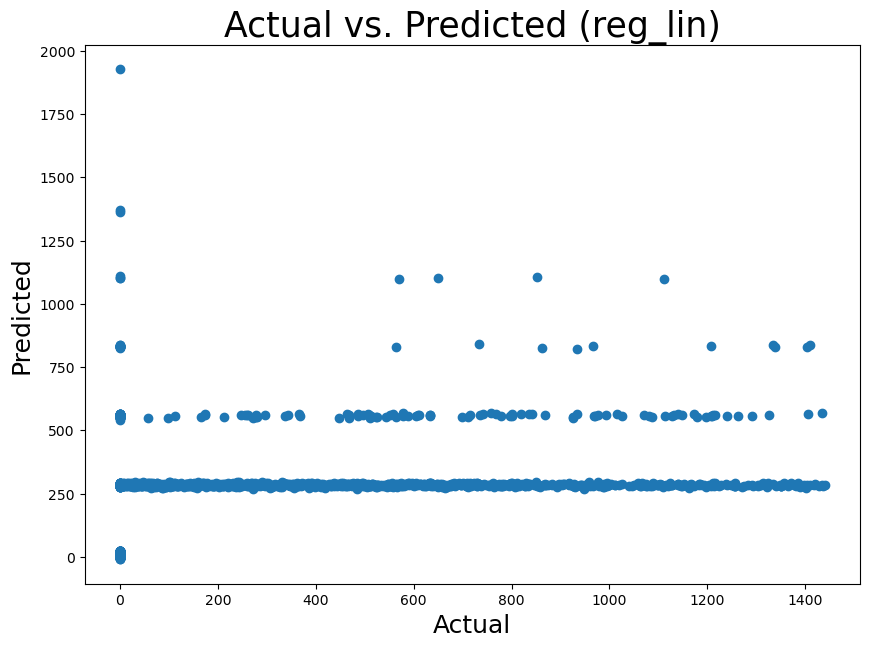

In [77]:
# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_Ind, y_train_Ind)

# Print intercept and coefficients
print("Intercept (reg_lin):", model.intercept_)
print("Coefficients (reg_lin):", model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin_Ind = model.predict(X_train_Ind)
test_predict_reg_lin_Ind = model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_absolute_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_absolute_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind)))
print("Test_reg_lin_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", r2_score(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", r2_score(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin_Ind, train_predict_reg_lin_Ind = np.array(y_train_Ind), np.array(train_predict_reg_lin_Ind)
mape_train_reg_lin_Ind = np.mean(np.abs((train_y_reg_lin_Ind - train_predict_reg_lin_Ind) / train_y_reg_lin_Ind)) * 100
print("MAPE_reg_lin_Ind - Mean Absolute Percentage Error:")
print("Train_reg_lin_Ind:", mape_train_reg_lin_Ind)
print("Test_reg_lin_Ind:", np.mean(np.abs((np.array(y_test_Ind) - np.array(test_predict_reg_lin_Ind)) / np.array(y_test_Ind))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_reg_lin_Ind)
plt.show()

#### 2. Polynomial Features

Polynomial Regression Metrics (poly_Ind):
Mean Squared Error (poly_Ind): 21180.71423942821
R-squared Score (poly_Ind): 0.4616231483193609
Intercept (poly_Ind): -11566533148.58877
Coefficients (poly_Ind): [-7.52451750e+07 -2.38481176e+10  4.29697521e+11 ...  0.00000000e+00
  0.00000000e+00 -6.22336482e+09]
MAE (poly_Ind):
Train_poly_Ind: 46.690172915938206
Test_poly_Ind: 50.32335598599728
MSE (poly_Ind):
Train_poly_Ind: 18473.603721377287
Test_poly_Ind: 21180.71423942821
RMSE (poly_Ind):
Train_poly_Ind: 135.91763579969043
Test_poly_Ind: 145.5359551431474
R2 SCORE (poly_Ind):
Train_poly_Ind: 0.5061629777485435
Test_poly_Ind: 0.4616231483193609
MAPE - Mean Absolute Percentage Error (poly_Ind):
Train_poly_Ind: inf
Test_poly_Ind: inf


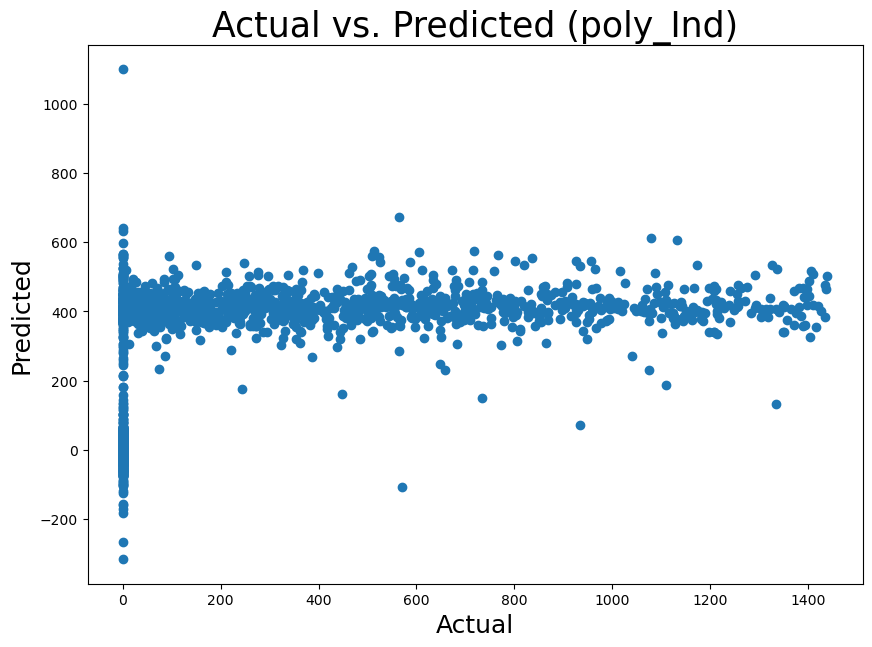

In [78]:
# Define the polynomial regression model
degree = 3  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_poly_Ind = poly_model.predict(X_test_Ind)

# Evaluate the model
mse_poly_Ind = mean_squared_error(y_test_Ind, y_pred_poly_Ind)
print("Polynomial Regression Metrics (poly_Ind):")
print(f"Mean Squared Error (poly_Ind): {mse_poly_Ind}")

r2_poly_Ind = r2_score(y_test_Ind, y_pred_poly_Ind)
print(f"R-squared Score (poly_Ind): {r2_poly_Ind}")

# Calculate other metrics
print("Intercept (poly_Ind):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_Ind):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly_Ind = poly_model.predict(X_train_Ind)
test_predict_poly_Ind = poly_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (poly_Ind):")
print("Train_poly_Ind:", mean_absolute_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_absolute_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (poly_Ind):")
print("Train_poly_Ind:", mean_squared_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_squared_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (poly_Ind):")
print("Train_poly_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_poly_Ind)))
print("Test_poly_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_poly_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (poly_Ind):")
print("Train_poly_Ind:", r2_score(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", r2_score(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_poly_Ind = np.mean(np.abs((y_train_Ind - train_predict_poly_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (poly_Ind):")
print("Train_poly_Ind:", mape_train_poly_Ind)
print("Test_poly_Ind:", np.mean(np.abs((y_test_Ind - test_predict_poly_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_poly_Ind)
plt.show()

#### 3. SVR

SVR Regression Metrics (svr_Ind):
Mean Squared Error (svr_Ind): 24846.765999345986
R-squared Score (svr_Ind): 0.3684385001393342
MAE (svr_Ind):
Train_svr_Ind: 41.1944727392687
Test_svr_Ind: 43.1403841680665
MSE (svr_Ind):
Train_svr_Ind: 23451.281719134553
Test_svr_Ind: 24846.765999345986
RMSE (svr_Ind):
Train_svr_Ind: 153.13811321527555
Test_svr_Ind: 157.62856974338752
R2 SCORE (svr_Ind):
Train_svr_Ind: 0.3730995150255393
Test_svr_Ind: 0.3684385001393342
MAPE - Mean Absolute Percentage Error (svr_Ind):
Train_svr_Ind: inf
Test_svr_Ind: inf


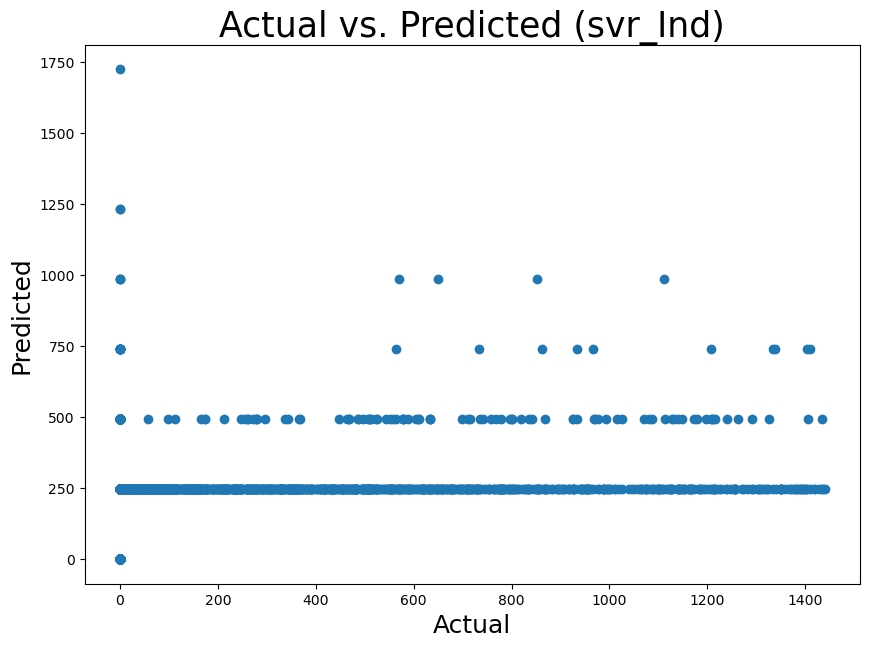

In [79]:
# Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_svr_Ind = svr_model.predict(X_test_Ind)

# Evaluate the model
mse_svr_Ind = mean_squared_error(y_test_Ind, y_pred_svr_Ind)
print("SVR Regression Metrics (svr_Ind):")
print(f"Mean Squared Error (svr_Ind): {mse_svr_Ind}")

r2_svr_Ind = r2_score(y_test_Ind, y_pred_svr_Ind)
print(f"R-squared Score (svr_Ind): {r2_svr_Ind}")

# Predicting on TRAIN & TEST DATA
train_predict_svr_Ind = svr_model.predict(X_train_Ind)
test_predict_svr_Ind = svr_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (svr_Ind):")
print("Train_svr_Ind:", mean_absolute_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_absolute_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (svr_Ind):")
print("Train_svr_Ind:", mean_squared_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_squared_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (svr_Ind):")
print("Train_svr_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_svr_Ind)))
print("Test_svr_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_svr_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (svr_Ind):")
print("Train_svr_Ind:", r2_score(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", r2_score(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_svr_Ind = np.mean(np.abs((y_train_Ind - train_predict_svr_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (svr_Ind):")
print("Train_svr_Ind:", mape_train_svr_Ind)
print("Test_svr_Ind:", np.mean(np.abs((y_test_Ind - test_predict_svr_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_svr_Ind)
plt.show()

#### 4. RandomForest

Random Forest Regression Metrics (rf_Ind):
Mean Squared Error (rf_Ind): 21915.07825572179
R-squared Score (rf_Ind): 0.4429568945466854
MAE (rf_Ind):
Train_rf_Ind: 15.234219240012205
Test_rf_Ind: 44.02658486363969
MSE (rf_Ind):
Train_rf_Ind: 2782.7666061710556
Test_rf_Ind: 21915.07825572179
RMSE (rf_Ind):
Train_rf_Ind: 52.751934620173465
Test_rf_Ind: 148.0374218085474
R2 SCORE (rf_Ind):
Train_rf_Ind: 0.925610985537052
Test_rf_Ind: 0.4429568945466854
MAPE - Mean Absolute Percentage Error (rf_Ind):
Train_rf_Ind: inf
Test_rf_Ind: inf


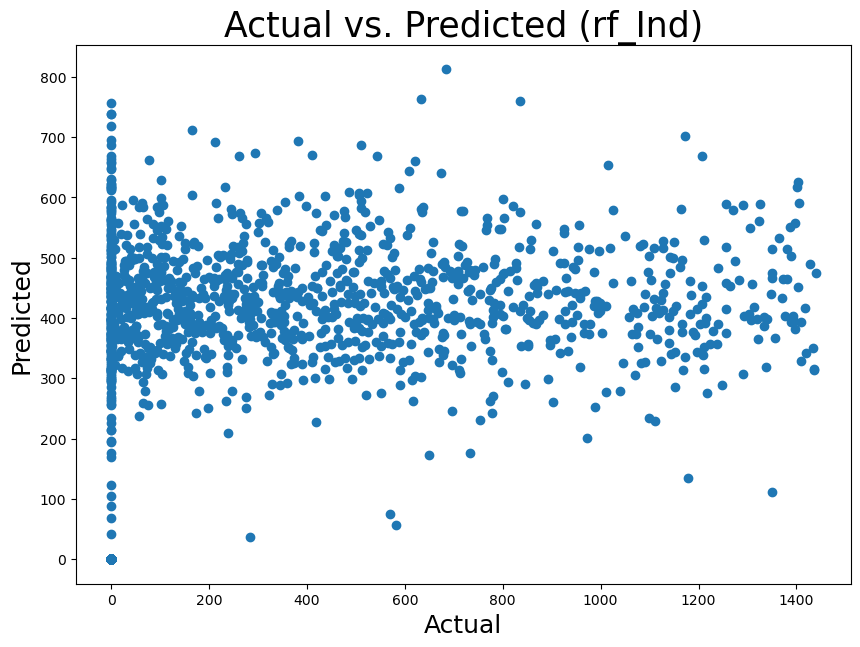

In [80]:
# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest regression model
rf_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_rf_Ind = rf_model.predict(X_test_Ind)

# Evaluate the model
mse_rf_Ind = mean_squared_error(y_test_Ind, y_pred_rf_Ind)
print("Random Forest Regression Metrics (rf_Ind):")
print(f"Mean Squared Error (rf_Ind): {mse_rf_Ind}")

r2_rf_Ind = r2_score(y_test_Ind, y_pred_rf_Ind)
print(f"R-squared Score (rf_Ind): {r2_rf_Ind}")

# Predicting on TRAIN & TEST DATA
train_predict_rf_Ind = rf_model.predict(X_train_Ind)
test_predict_rf_Ind = rf_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (rf_Ind):")
print("Train_rf_Ind:", mean_absolute_error(y_train_Ind, train_predict_rf_Ind))
print("Test_rf_Ind:", mean_absolute_error(y_test_Ind, test_predict_rf_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (rf_Ind):")
print("Train_rf_Ind:", mean_squared_error(y_train_Ind, train_predict_rf_Ind))
print("Test_rf_Ind:", mean_squared_error(y_test_Ind, test_predict_rf_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (rf_Ind):")
print("Train_rf_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_rf_Ind)))
print("Test_rf_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_rf_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (rf_Ind):")
print("Train_rf_Ind:", r2_score(y_train_Ind, train_predict_rf_Ind))
print("Test_rf_Ind:", r2_score(y_test_Ind, test_predict_rf_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_Ind = np.mean(np.abs((y_train_Ind - train_predict_rf_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (rf_Ind):")
print("Train_rf_Ind:", mape_train_rf_Ind)
print("Test_rf_Ind:", np.mean(np.abs((y_test_Ind - test_predict_rf_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_rf_Ind)
plt.show()

#### 5. RandomForest with Grid search

Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind):
Mean Squared Error (RF_GSCV_Ind): 20765.68571331966
R-squared Score (RF_GSCV_Ind): 0.4721724503267519
Best parameters found by GridSearchCV (RF_GSCV_Ind):
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
MAE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 40.06611828307202
Test_RF_GSCV_Ind: 42.898673162083355
MSE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 18767.75093714538
Test_RF_GSCV_Ind: 20765.68571331966
RMSE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 136.99544130059724
Test_RF_GSCV_Ind: 144.10303852910133
R2 SCORE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 0.4982998240656279
Test_RF_GSCV_Ind: 0.4721724503267519
MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind):
Train_RF_GSCV_Ind: inf
Test_RF_GSCV_Ind: inf


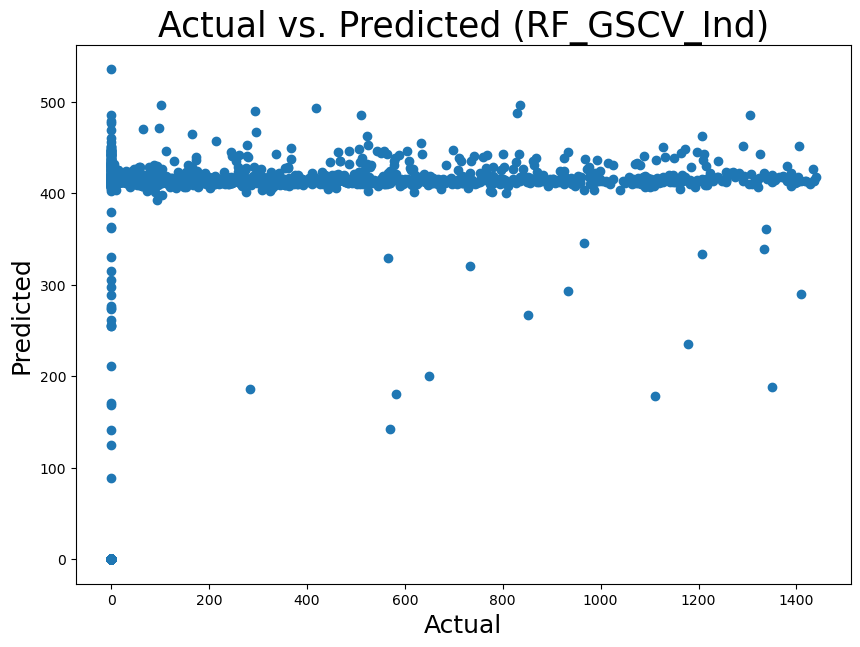

In [81]:
# Define the parameter grid for GridSearchCV
param_grid_RF_GSCV = {
    'n_estimators': [1000, 2000, 3000],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model for GridSearchCV
rf_model_RF_GSCV = RandomForestRegressor(random_state=42)

# Create GridSearchCV object for Random Forest
grid_search_RF_GSCV = GridSearchCV(estimator=rf_model_RF_GSCV, param_grid=param_grid_RF_GSCV, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search_RF_GSCV.fit(X_train_Ind, y_train_Ind)

# Get the best model
best_rf_model_RF_GSCV = grid_search_RF_GSCV.best_estimator_

# Make predictions
y_pred_rf_grid_Ind = best_rf_model_RF_GSCV.predict(X_test_Ind)

# Evaluate the model
mse_rf_grid_Ind = mean_squared_error(y_test_Ind, y_pred_rf_grid_Ind)
print("Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind):")
print(f"Mean Squared Error (RF_GSCV_Ind): {mse_rf_grid_Ind}")

r2_rf_grid_Ind = r2_score(y_test_Ind, y_pred_rf_grid_Ind)
print(f"R-squared Score (RF_GSCV_Ind): {r2_rf_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV (RF_GSCV_Ind):")
print(grid_search_RF_GSCV.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mean_absolute_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", mean_absolute_error(y_test_Ind, y_pred_rf_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", mse_rf_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind))))
print("Test_RF_GSCV_Ind:", np.sqrt(mse_rf_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", r2_score(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", r2_rf_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_Ind = np.mean(np.abs((y_train_Ind - best_rf_model_RF_GSCV.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mape_train_rf_Ind)
print("Test_RF_GSCV_Ind:", np.mean(np.abs((y_test_Ind - y_pred_rf_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (RF_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_rf_grid_Ind)
plt.show()

#### 6. XGBoost

XGBoost Regression Metrics (XGB_Ind):
Mean Squared Error (XGB_Ind): 22418.861871838773
R-squared Score (XGB_Ind): 0.43015159279399673
MAE (XGB_Ind):
Train_Ind: 32.813021266883
Test_Ind: 44.988317434288454
MSE (XGB_Ind):
Train_Ind: 12321.715120893066
Test_Ind: 22418.861871838773
RMSE (XGB_Ind):
Train_Ind: 111.00322121854423
Test_Ind: 149.72929530268541
R2 SCORE (XGB_Ind):
Train_Ind: 0.6706154794642893
Test_Ind: 0.43015159279399673
MAPE - Mean Absolute Percentage Error (XGB_Ind):
Train_Ind: inf
Test_Ind: inf


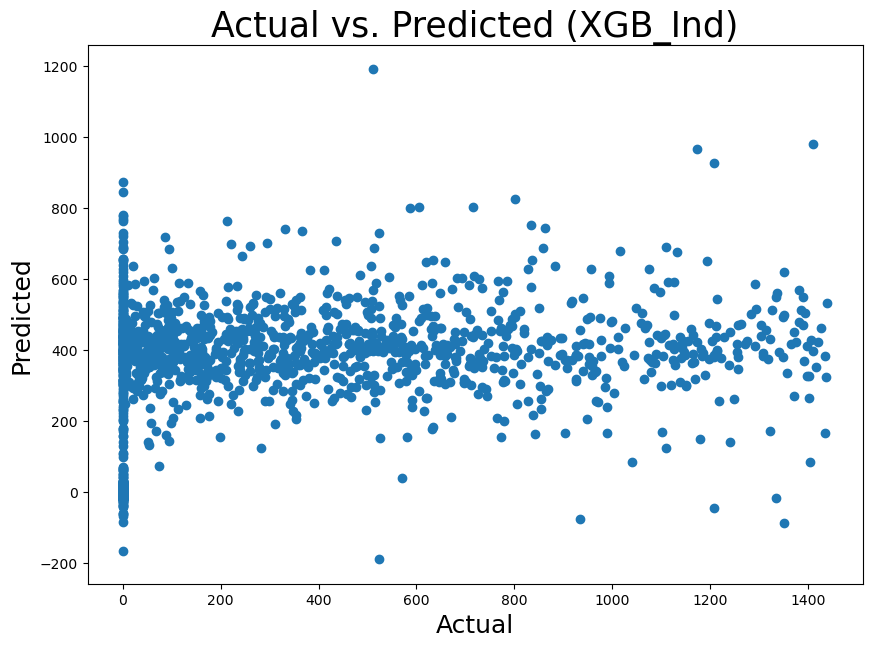

In [82]:
# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Train the XGBoost regression model
xgb_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_xgb_Ind = xgb_model.predict(X_test_Ind)

# Evaluate the model
mse_xgb_Ind = mean_squared_error(y_test_Ind, y_pred_xgb_Ind)
print("XGBoost Regression Metrics (XGB_Ind):")
print(f"Mean Squared Error (XGB_Ind): {mse_xgb_Ind}")

r2_xgb_Ind = r2_score(y_test_Ind, y_pred_xgb_Ind)
print(f"R-squared Score (XGB_Ind): {r2_xgb_Ind}")

# Print MAE (Mean Absolute Error)
print("MAE (XGB_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_xgb_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (XGB_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mse_xgb_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (XGB_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, xgb_model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_xgb_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (XGB_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, xgb_model.predict(X_train_Ind)))
print("Test_Ind:", r2_xgb_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_Ind = np.mean(np.abs((y_train_Ind - xgb_model.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (XGB_Ind):")
print("Train_Ind:", mape_train_xgb_Ind)
print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_xgb_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (XGB_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_xgb_Ind)
plt.show()

#### 7. XGBoost with GridSearch

XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:
Mean Squared Error (xgb_GSCV_Ind): 20753.2211186861
R-squared Score (xgb_GSCV_Ind): 0.47248927860461054
Best parameters found by GridSearchCV:
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 900}
MAE (xgb_GSCV_Ind):
Train_Ind: 40.46031040893879
Test_Ind: 43.140704105410926
MSE (xgb_GSCV_Ind):
Train_Ind: 18890.051916866192
Test_Ind: 20753.2211186861
RMSE (xgb_GSCV_Ind):
Train_Ind: 137.44108525788857
Test_Ind: 144.05978314118795
R2 SCORE (xgb_GSCV_Ind):
Train_Ind: 0.49503046998860656
Test_Ind: 0.47248927860461054
MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):
Train_Ind: inf
Test_Ind: inf


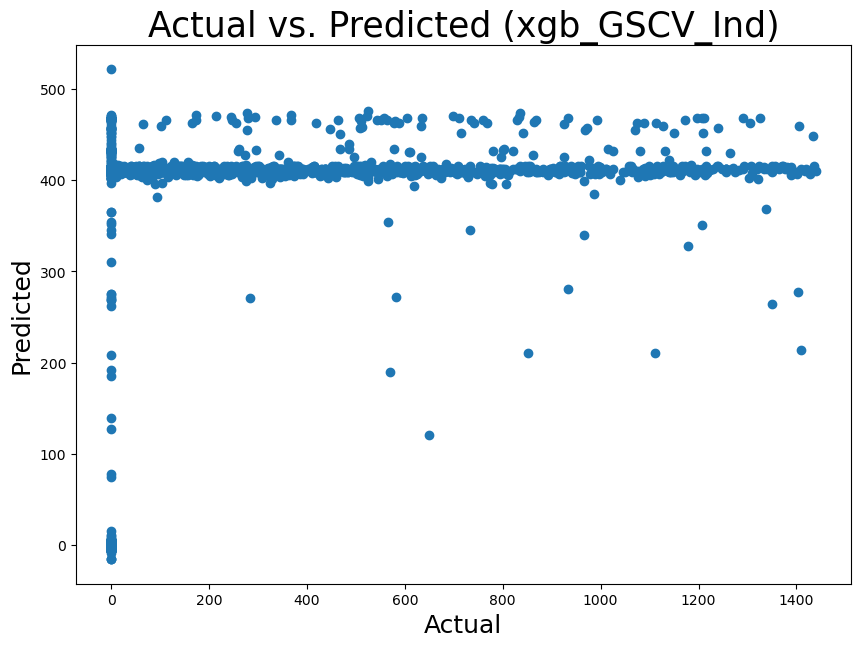

In [83]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_Ind, y_train_Ind)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_Ind = best_xgb_model.predict(X_test_Ind)

# Evaluate the model
mse_xgb_grid_Ind = mean_squared_error(y_test_Ind, y_pred_xgb_grid_Ind)
print("XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:")
print(f"Mean Squared Error (xgb_GSCV_Ind): {mse_xgb_grid_Ind}")

r2_xgb_grid_Ind = r2_score(y_test_Ind, y_pred_xgb_grid_Ind)
print(f"R-squared Score (xgb_GSCV_Ind): {r2_xgb_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_xgb_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mse_xgb_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (xgb_GSCV_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_xgb_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (xgb_GSCV_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", r2_xgb_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_Ind = np.mean(np.abs((y_train_Ind - best_xgb_model.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):")
print("Train_Ind:", mape_train_xgb_Ind)
print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_xgb_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (xgb_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_xgb_grid_Ind)
plt.show()


#### 8. ANN model

In [84]:
### Define the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_Ind.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add a dropout layer for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_Ind, y_train_Ind, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
mse_rnn_Ind = model.evaluate(X_test_Ind, y_test_Ind)
print("Mean Squared Error (ANN_Ind):", mse_rnn_Ind)

# Make predictions on the test set
y_pred_rnn_Ind = model.predict(X_test_Ind)

# Calculate the coefficient of determination R^2
r2_rnn_Ind = r2_score(y_test_Ind, y_pred_rnn_Ind)
print("R-squared Score (ANN_Ind):", r2_rnn_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (ANN_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_rnn_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (ANN_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, model.predict(X_train_Ind)))
print("Test_Ind:", mse_rnn_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (ANN_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_rnn_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (ANN_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, model.predict(X_train_Ind)))
print("Test_Ind:", r2_rnn_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
#mape_train_rnn_Ind = np.mean(np.abs((y_train_Ind - model.predict(X_train_Ind)) / y_train_Ind)) * 100
#print("MAPE - Mean Absolute Percentage Error (ANN_Ind):")
#print("Train_Ind:", mape_train_rnn_Ind)
#print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_rnn_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
#plt.figure(figsize=(10, 7))
#plt.title("Actual vs. Predicted (ANN_Ind)", fontsize=25)
#plt.xlabel("Actual", fontsize=18)
#plt.ylabel("Predicted", fontsize=18)
#plt.scatter(x=y_test_Ind, y=y_pred_rnn_Ind)
#plt.show()

Epoch 1/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 27304.1738 - val_loss: 19891.6738
Epoch 2/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 21268.5957 - val_loss: 19171.4023
Epoch 3/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 20527.0801 - val_loss: 18704.6582
Epoch 4/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 19131.2188 - val_loss: 18600.3418
Epoch 5/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 20901.8613 - val_loss: 18904.7480
Epoch 6/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 19315.5488 - val_loss: 18585.1797
Epoch 7/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 19932.6055 - val_loss: 18631.3848
Epoch 8/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 19476.3535 - val_loss: 18506.1660
Epoch 9/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 19379.0586 - val_loss: 18550.4141
Epoch 10/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 18777.2754 - val_loss: 18694.8789
Epoch 11/50
2251/2251 ━━━━━━━━━━━━━━━━━

#### Step B. Predicting the Primeppd : 

#### 1. Linear Regression

Intercept (reg_lin_model): 59.58936591740851
Coefficients (reg_lin_model): [ 2.14216222e+00  7.96133268e-01 -8.19170921e-01 -5.00708026e-02
 -5.52538732e-01 -5.78208181e-02 -3.17792308e-01  2.18203406e+02
  3.04643979e+01  1.20503394e+00 -4.34746110e-01 -3.30230798e-01
 -2.06076111e+00  1.24794109e+00  3.23215297e+00 -1.65435604e+00
 -7.90734672e-01  6.53320476e-01  1.37414196e-01]
MAE_reg_lin_model:
Train_reg_lin_model: 26.45106945375991
Test_reg_lin_model: 27.251804845120564
MSE_reg_lin_model:
Train_reg_lin_model: 9252.044242588308
Test_reg_lin_model: 10364.986538079707
RMSE_reg_lin_model:
Train_reg_lin_model: 96.18754723241626
Test_reg_lin_model: 101.80857791993613
R2_SCORE_reg_lin_model:
Train_reg_lin_model: 0.8595161977035296
Test_reg_lin_model: 0.8508020130908809
MAPE_reg_lin_model - Mean Absolute Percentage Error:
Train_reg_lin_model: inf
Test_reg_lin_model: inf


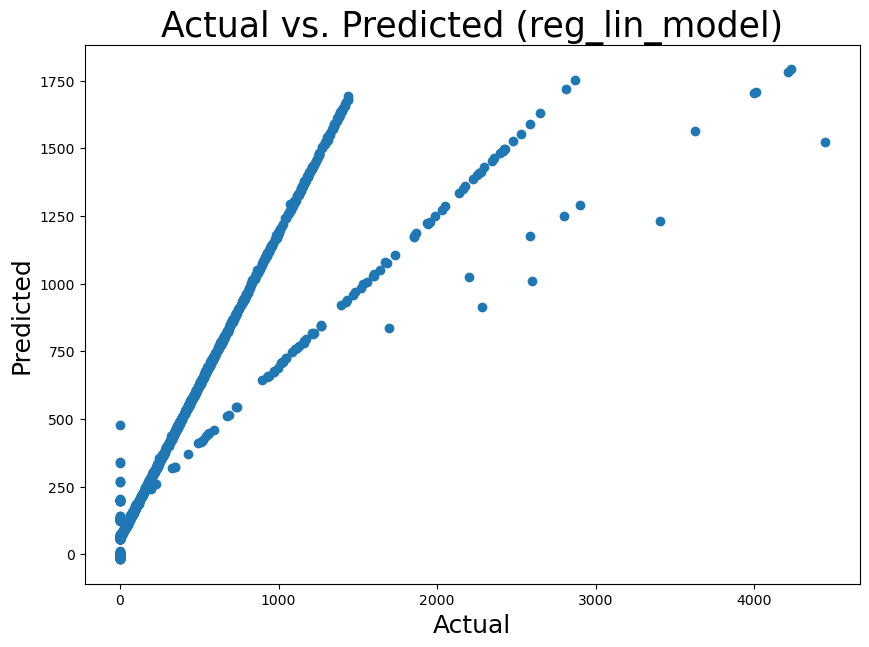

In [101]:
# Instantiate the Linear Regression model
reg_lin_model = LinearRegression()

# Fit the model on the training data
reg_lin_model.fit(X_train, y_train)

# Print intercept and coefficients
print("Intercept (reg_lin_model):", reg_lin_model.intercept_)
print("Coefficients (reg_lin_model):", reg_lin_model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin = reg_lin_model.predict(X_train)
test_predict_reg_lin = reg_lin_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_model:")
print("Train_reg_lin_model:", mean_absolute_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_absolute_error(y_test, test_predict_reg_lin))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_model:")
print("Train_reg_lin_model:", mean_squared_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_squared_error(y_test, test_predict_reg_lin))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_model:")
print("Train_reg_lin_model:", np.sqrt(mean_squared_error(y_train, train_predict_reg_lin)))
print("Test_reg_lin_model:", np.sqrt(mean_squared_error(y_test, test_predict_reg_lin)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_model:")
print("Train_reg_lin_model:", r2_score(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", r2_score(y_test, test_predict_reg_lin))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin, train_predict_reg_lin = np.array(y_train), np.array(train_predict_reg_lin)
mape_train_reg_lin = np.mean(np.abs((train_y_reg_lin - train_predict_reg_lin) / train_y_reg_lin)) * 100
print("MAPE_reg_lin_model - Mean Absolute Percentage Error:")
print("Train_reg_lin_model:", mape_train_reg_lin)
print("Test_reg_lin_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_reg_lin)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_reg_lin)
plt.show()


#### 2. Polynomial Features

Polynomial Regression Metrics:
Mean Squared Error: 1.1032174730388242e-23
R-squared Score: 1.0
Intercept (poly_model): 396.1679598614303
Coefficients (poly_model): [-5.82689220e-03  1.22868561e+00 -1.60478505e+01 -1.15138769e-01
 -1.80984131e+00 -8.72157049e-01  1.36032483e-01  2.15138498e-01
  2.55532033e+01  1.90470129e+01  1.41525914e+00 -1.47477450e-02
 -9.82328261e-02  2.62159256e-02 -7.69035252e-02 -1.47175277e-01
  3.56773683e-02 -1.01953832e-01  1.11132771e-03 -1.40550270e-01
  5.20694599e-14 -3.10862447e-14 -3.55271368e-15 -3.37507799e-14
 -7.49816875e-14 -4.26325641e-14  0.00000000e+00  5.95079541e-14
 -3.35287353e-14  3.99680289e-14  2.00999821e-01  2.00999821e-01
  2.00999821e-01  2.00999821e-01  2.00999821e-01  2.00999821e-01
 -1.42968543e+00 -1.42968543e+00 -1.42968543e+00 -3.88487994e+02
  2.66453526e-14  7.46069873e-14 -2.88657986e-14  2.93098879e-14
  5.37347944e-14 -8.59312621e-14 -1.37667655e-14  4.50750548e-14
 -2.78976242e+00 -2.78976242e+00 -2.78976242e+00 -2.7897

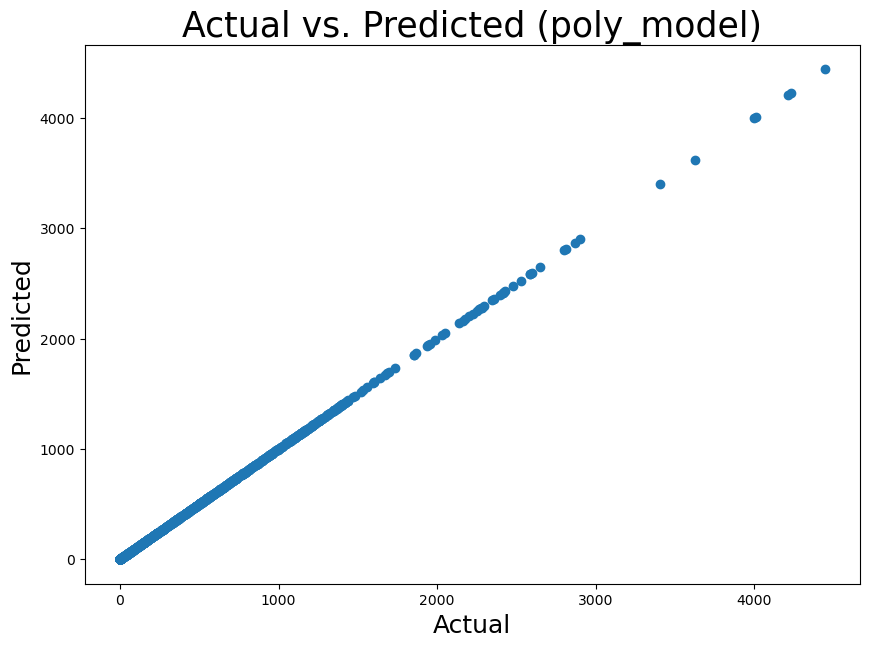

In [102]:
# Define the polynomial regression model
degree = 2  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train, y_train)

# Make predictions
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print("Polynomial Regression Metrics:")
print(f"Mean Squared Error: {mse_poly}")

r2_poly = r2_score(y_test, y_pred_poly)
print(f"R-squared Score: {r2_poly}")

# Calculate other metrics
print("Intercept (poly_model):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_model):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly = poly_model.predict(X_train)
test_predict_poly = poly_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_poly_model:")
print("Train_poly_model:", mean_absolute_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_absolute_error(y_test, test_predict_poly))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_poly_model:")
print("Train_poly_model:", mean_squared_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_squared_error(y_test, test_predict_poly))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_poly_model:")
print("Train_poly_model:", np.sqrt(mean_squared_error(y_train, train_predict_poly)))
print("Test_poly_model:", np.sqrt(mean_squared_error(y_test, test_predict_poly)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_poly_model:")
print("Train_poly_model:", r2_score(y_train, train_predict_poly))
print("Test_poly_model:", r2_score(y_test, test_predict_poly))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_poly, train_predict_poly = np.array(y_train), np.array(train_predict_poly)
mape_train_poly = np.mean(np.abs((train_y_poly - train_predict_poly) / train_y_poly)) * 100
print("MAPE_poly_model - Mean Absolute Percentage Error:")
print("Train_poly_model:", mape_train_poly)
print("Test_poly_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_poly)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_poly)
plt.show()



#### 3. SVR

SVR Regression Metrics:
Mean Squared Error: 9417.553001439604
R-squared Score: 0.9554235377243832
MAE:
Train: 1.6206549145590217
Test: 2.8542857444400327
MSE:
Train: 5694.51646346309
Test: 9417.553001439604
RMSE:
Train: 75.46202000651115
Test: 97.0440776216643
R2 SCORE:
Train: 0.9687297437092127
Test: 0.9554235377243832
MAPE - Mean Absolute Percentage Error:
Train: inf
Test: inf


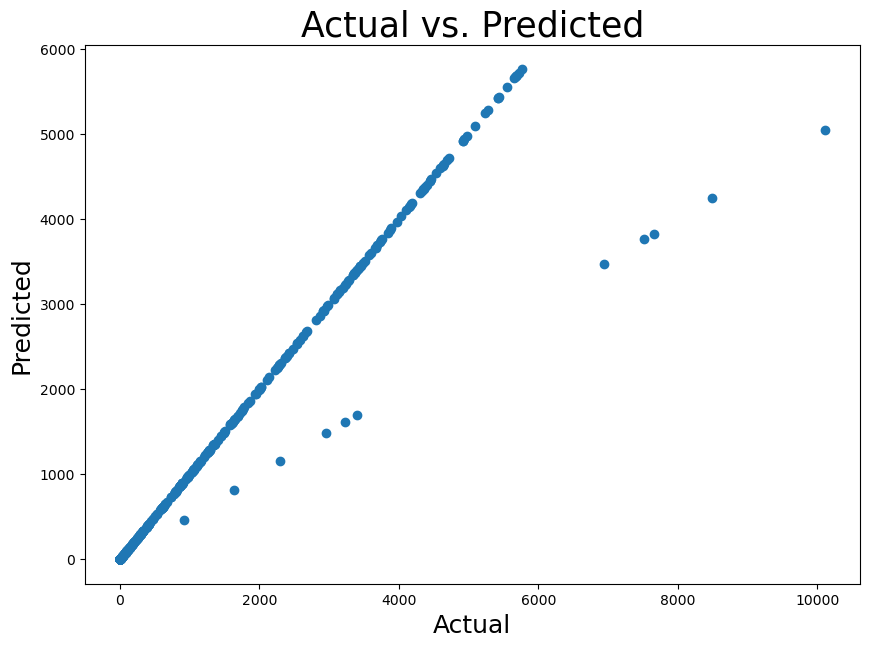

In [51]:
# Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
print("SVR Regression Metrics:")
print(f"Mean Squared Error (svr_model): {mse_svr}")

r2_svr = r2_score(y_test, y_pred_svr)
print(f"R-squared Score (svr_model): {r2_svr}")

# Predicting on TRAIN & TEST DATA
train_predict_svr = svr_model.predict(X_train)
test_predict_svr = svr_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_svr_model:")
print("Train_svr_model:", mean_absolute_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_absolute_error(y_test, test_predict_svr))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_svr_model:")
print("Train_svr_model:", mean_squared_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_squared_error(y_test, test_predict_svr))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_svr_model:")
print("Train_svr_model:", np.sqrt(mean_squared_error(y_train, train_predict_svr)))
print("Test_svr_model:", np.sqrt(mean_squared_error(y_test, test_predict_svr)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_svr_model:")
print("Train_svr_model:", r2_score(y_train, train_predict_svr))
print("Test_svr_model:", r2_score(y_test, test_predict_svr))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_svr, train_predict_svr = np.array(y_train), np.array(train_predict_svr)
mape_train_svr = np.mean(np.abs((train_y_svr - train_predict_svr) / train_y_svr)) * 100
print("MAPE_svr_model - Mean Absolute Percentage Error:")
print("Train_svr_model:", mape_train_svr)
print("Test_svr_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_svr)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_svr)
plt.show()

#### 4. RandomForest

Random Forest Regression Metrics:
Mean Squared Error (rf_model): 134.70706459735734
R-squared Score (rf_model): 0.9980609697092684
MAE_rf_model:
Train_rf_model: 0.047909469817974615
Test_rf_model: 0.2845830117141191
MSE_rf_model:
Train_rf_model: 5.227298479548099
Test_rf_model: 134.70706459735734
RMSE_rf_model:
Train_rf_model: 2.286328602705241
Test_rf_model: 11.606337260193559
R2_SCORE_rf_model:
Train_rf_model: 0.9999206282690732
Test_rf_model: 0.9980609697092684
MAPE_rf_model - Mean Absolute Percentage Error:
Train_rf_model: nan
Test_rf_model: nan


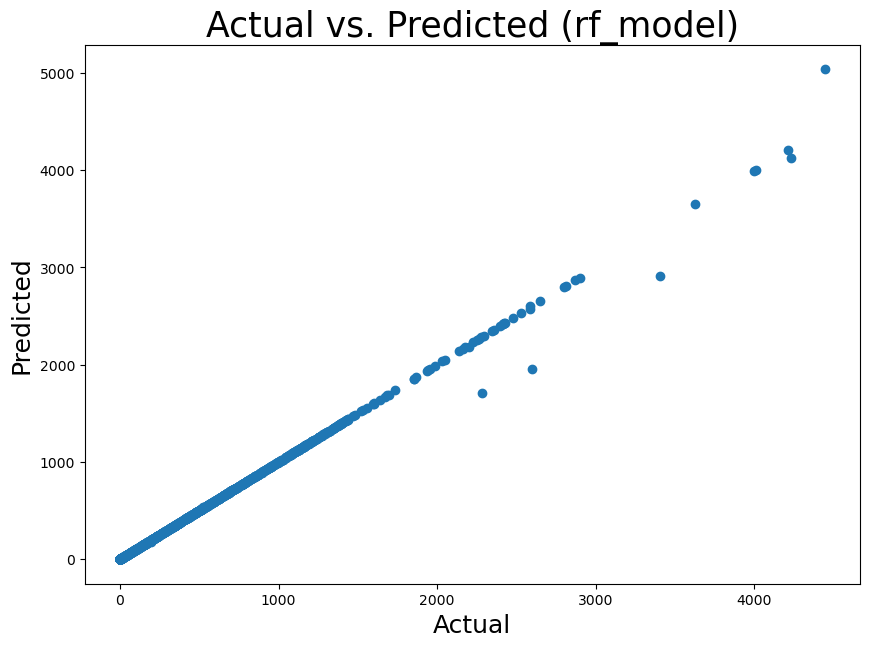

In [103]:
# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest regression model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf_model = rf_model.predict(X_test)

# Evaluate the model
mse_rf_model = mean_squared_error(y_test, y_pred_rf_model)
print("Random Forest Regression Metrics:")
print(f"Mean Squared Error (rf_model): {mse_rf_model}")

r2_rf_model = r2_score(y_test, y_pred_rf_model)
print(f"R-squared Score (rf_model): {r2_rf_model}")

# Predicting on TRAIN & TEST DATA
train_predict_rf_model = rf_model.predict(X_train)
test_predict_rf_model = rf_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_rf_model:")
print("Train_rf_model:", mean_absolute_error(y_train, train_predict_rf_model))
print("Test_rf_model:", mean_absolute_error(y_test, test_predict_rf_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_rf_model:")
print("Train_rf_model:", mean_squared_error(y_train, train_predict_rf_model))
print("Test_rf_model:", mean_squared_error(y_test, test_predict_rf_model))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_rf_model:")
print("Train_rf_model:", np.sqrt(mean_squared_error(y_train, train_predict_rf_model)))
print("Test_rf_model:", np.sqrt(mean_squared_error(y_test, test_predict_rf_model)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_rf_model:")
print("Train_rf_model:", r2_score(y_train, train_predict_rf_model))
print("Test_rf_model:", r2_score(y_test, test_predict_rf_model))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_rf_model, train_predict_rf_model = np.array(y_train), np.array(train_predict_rf_model)
mape_train_rf_model = np.mean(np.abs((train_y_rf_model - train_predict_rf_model) / train_y_rf_model)) * 100
print("MAPE_rf_model - Mean Absolute Percentage Error:")
print("Train_rf_model:", mape_train_rf_model)
print("Test_rf_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_rf_model)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_rf_model)
plt.show()


#### 5. RandomForest with Grid Search

Random Forest Regression Metrics (with GridSearchCV):
Mean Squared Error (rf_grid_model): 134.70706459735734
R-squared Score (rf_grid_model): 0.9980609697092684
Best parameters found by GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE_rf_grid_model:
Train_rf_grid_model: 0.047909469817974615
Test_rf_grid_model: 0.2845830117141191
MSE_rf_grid_model:
Train_rf_grid_model: 5.227298479548099
Test_rf_grid_model: 134.70706459735734
RMSE_rf_grid_model:
Train_rf_grid_model: 2.286328602705241
Test_rf_grid_model: 11.606337260193559
R2_SCORE_rf_grid_model:
Train_rf_grid_model: 0.9999206282690732
Test_rf_grid_model: 0.9980609697092684
MAPE_rf_grid_model - Mean Absolute Percentage Error:
Train_rf_grid_model: 0.06045978787898287
Test_rf_grid_model: 0.18296851701480638


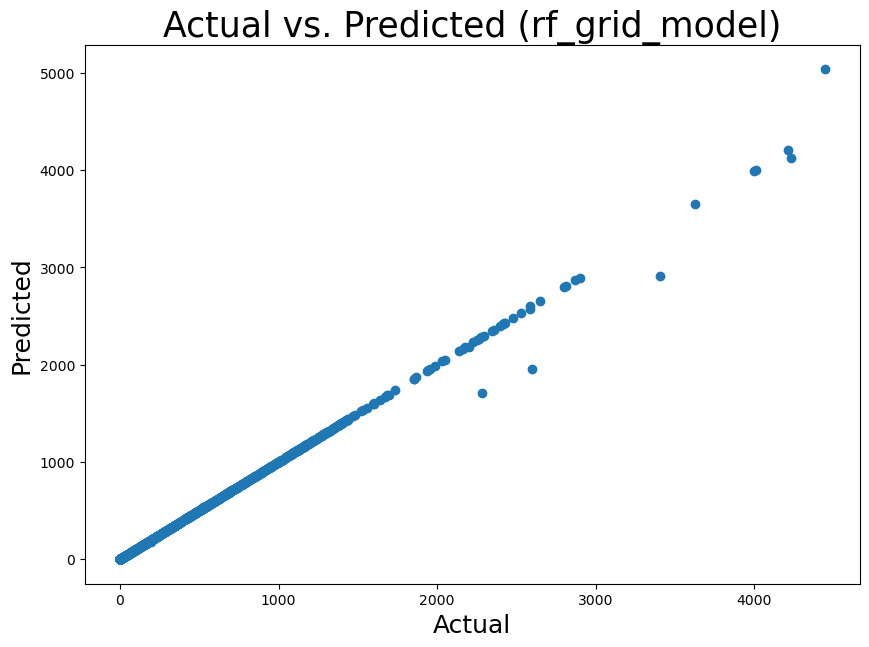

In [104]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_rf_grid_model = best_rf_model.predict(X_test)

# Evaluate the model
mse_rf_grid_model = mean_squared_error(y_test, y_pred_rf_grid_model)
print("Random Forest Regression Metrics (with GridSearchCV):")
print(f"Mean Squared Error (rf_grid_model): {mse_rf_grid_model}")

r2_rf_grid_model = r2_score(y_test, y_pred_rf_grid_model)
print(f"R-squared Score (rf_grid_model): {r2_rf_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_rf_grid_model:")
print("Train_rf_grid_model:", mean_absolute_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mean_absolute_error(y_test, y_pred_rf_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_rf_grid_model:")
print("Train_rf_grid_model:", mean_squared_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mse_rf_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_rf_grid_model:")
print("Train_rf_grid_model:", np.sqrt(mean_squared_error(y_train, best_rf_model.predict(X_train))))
print("Test_rf_grid_model:", np.sqrt(mse_rf_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_rf_grid_model:")
print("Train_rf_grid_model:", r2_score(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", r2_rf_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_grid_model = np.mean(np.abs((y_train - best_rf_model.predict(X_train)) / y_train)) * 100
print("MAPE_rf_grid_model - Mean Absolute Percentage Error:")
print("Train_rf_grid_model:", mape_train_rf_grid_model)
print("Test_rf_grid_model:", np.mean(np.abs((y_test - y_pred_rf_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_grid_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_rf_grid_model)
plt.show()

#### 6. XGBoost

XGBoost Regression Metrics (xgb_model):
Mean Squared Error (xgb_model): 101.67623558259646
R-squared Score (xgb_model): 0.9985364293904591
MAE_xgb_model:
Train_xgb_model: 0.15340626123694595
Test_xgb_model: 0.38814677128366615
MSE_xgb_model:
Train_xgb_model: 0.4947120089367544
Test_xgb_model: 101.67623558259646
RMSE_xgb_model:
Train_xgb_model: 0.7033576678594997
Test_xgb_model: 10.083463471575453
R2_SCORE_xgb_model:
Train_xgb_model: 0.9999924882520841
Test_xgb_model: 0.9985364293904591
MAPE_xgb_model - Mean Absolute Percentage Error:
Train_xgb_model: inf
Test_xgb_model: inf


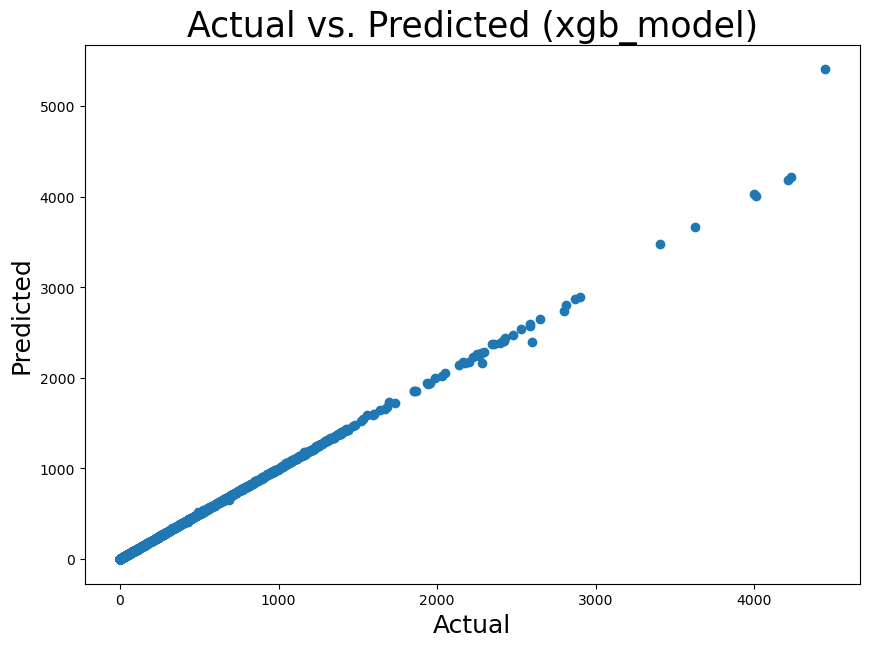

In [105]:
# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Train the XGBoost regression model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb_model = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb_model = mean_squared_error(y_test, y_pred_xgb_model)
print("XGBoost Regression Metrics (xgb_model):")
print(f"Mean Squared Error (xgb_model): {mse_xgb_model}")

r2_xgb_model = r2_score(y_test, y_pred_xgb_model)
print(f"R-squared Score (xgb_model): {r2_xgb_model}")

# Print MAE (Mean Absolute Error)
print("MAE_xgb_model:")
print("Train_xgb_model:", mean_absolute_error(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", mean_absolute_error(y_test, y_pred_xgb_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_xgb_model:")
print("Train_xgb_model:", mean_squared_error(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", mse_xgb_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_xgb_model:")
print("Train_xgb_model:", np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train))))
print("Test_xgb_model:", np.sqrt(mse_xgb_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_xgb_model:")
print("Train_xgb_model:", r2_score(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", r2_xgb_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_model = np.mean(np.abs((y_train - xgb_model.predict(X_train)) / y_train)) * 100
print("MAPE_xgb_model - Mean Absolute Percentage Error:")
print("Train_xgb_model:", mape_train_xgb_model)
print("Test_xgb_model:", np.mean(np.abs((y_test - y_pred_xgb_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (xgb_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_xgb_model)
plt.show()

#### 7. XGBoost with Grid Search

XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):
Mean Squared Error (best_xgb_model_grid): 79.67327537581629
R-squared Score (best_xgb_model_grid): 0.9988531492778253
Best parameters found by GridSearchCV:
{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 900}
MAE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.22436817780586615
Test_best_xgb_model_grid: 0.4209922471507071
MSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 1.2985418627904075
Test_best_xgb_model_grid: 79.67327537581629
RMSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 1.139535810227308
Test_best_xgb_model_grid: 8.925988761802039
R2_SCORE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.9999802828333347
Test_best_xgb_model_grid: 0.9988531492778253
MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:
Train_best_xgb_model_grid: inf
Test_best_xgb_model_grid: inf


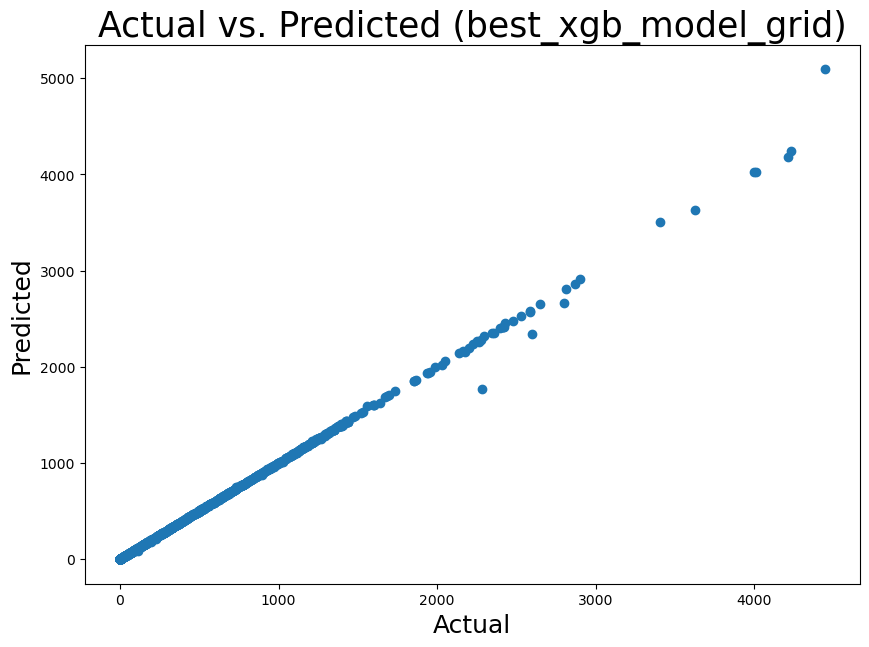

In [106]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model_grid = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_model = best_xgb_model_grid.predict(X_test)

# Evaluate the model
mse_xgb_grid_model = mean_squared_error(y_test, y_pred_xgb_grid_model)
print("XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):")
print(f"Mean Squared Error (best_xgb_model_grid): {mse_xgb_grid_model}")

r2_xgb_grid_model = r2_score(y_test, y_pred_xgb_grid_model)
print(f"R-squared Score (best_xgb_model_grid): {r2_xgb_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_absolute_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mean_absolute_error(y_test, y_pred_xgb_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_squared_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mse_xgb_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", np.sqrt(mean_squared_error(y_train, best_xgb_model_grid.predict(X_train))))
print("Test_best_xgb_model_grid:", np.sqrt(mse_xgb_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", r2_score(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", r2_xgb_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_grid_model = np.mean(np.abs((y_train - best_xgb_model_grid.predict(X_train)) / y_train)) * 100
print("MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:")
print("Train_best_xgb_model_grid:", mape_train_xgb_grid_model)
print("Test_best_xgb_model_grid:", np.mean(np.abs((y_test - y_pred_xgb_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (best_xgb_model_grid)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_xgb_grid_model)
plt.show()


#### 8. ANN

In [108]:
# Define the ANN model
ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add a dropout layer for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.Dense(1)
])

# Compile the model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
mse_ann = ann_model.evaluate(X_test, y_test)
print("Mean Squared Error (ann_model):", mse_ann)

# Make predictions on the test set
y_pred_ann_model = ann_model.predict(X_test)

# Calculate the coefficient of determination R^2
r2_ann_model = r2_score(y_test, y_pred_ann_model)
print("R-squared Score (ann_model):", r2_ann_model)

# Print MAE (Mean Absolute Error)
print("MAE_ann_model:")
print("Train_ann_model:", mean_absolute_error(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", mean_absolute_error(y_test, y_pred_ann_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_ann_model:")
print("Train_ann_model:", mean_squared_error(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", mse_ann)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_ann_model:")
print("Train_ann_model:", np.sqrt(mean_squared_error(y_train, ann_model.predict(X_train))))
print("Test_ann_model:", np.sqrt(mse_ann))
print("====================================")

# Print R2 SCORE
print("R2 SCORE_ann_model:")
print("Train_ann_model:", r2_score(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", r2_ann_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
#mape_train_ann_model = np.mean(np.abs((y_train - ann_model.predict(X_train)) / y_train)) * 100
#print("MAPE_ann_model - Mean Absolute Percentage Error:")
#print("Train_ann_model:", mape_train_ann_model)
#print("Test_ann_model:", np.mean(np.abs((y_test - y_pred_ann_model) / y_test)) * 100)

# Plot actual vs predicted value
#plt.figure(figsize=(10, 7))
#plt.title("Actual vs. Predicted (ann_model)", fontsize=25)
#plt.xlabel("Actual", fontsize=18)
#plt.ylabel("Predicted", fontsize=18)
#plt.scatter(x=y_test, y=y_pred_ann_model)
#plt.show()


Epoch 1/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 32056.9492 - val_loss: 6682.0806
Epoch 2/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6410.0947 - val_loss: 3068.9639
Epoch 3/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3652.7539 - val_loss: 1226.7849
Epoch 4/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2205.1223 - val_loss: 872.4929
Epoch 5/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1958.8463 - val_loss: 531.2617
Epoch 6/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1850.3441 - val_loss: 478.5790
Epoch 7/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1682.4596 - val_loss: 407.0788
Epoch 8/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1583.4602 - val_loss: 319.9480
Epoch 9/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1315.7401 - val_loss: 257.8185
Epoch 10/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1222.2849 - val_loss: 187.4015
Epoch 11/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 12

#### Step 5. Interpretability

In [92]:

# List of model names
model_names = ['Linear Regression', 'Polynomial Regression', 'SVR', 'Random Forest', 'Random Forest With GridSearch', 'XGBoost', 'XGBoost With GridSearch', 'ANN']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin_Ind, test_predict_poly_Ind, test_predict_svr_Ind, test_predict_rf_Ind, y_pred_rf_grid_Ind, y_pred_xgb_Ind, y_pred_xgb_grid_Ind, y_pred_rnn_Ind]

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_test_Ind, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_test_Ind, y_pred) for y_pred in all_y_pred]
}

# Debugging: Print shapes of all_y_pred
for i, y_pred in enumerate(all_y_pred):
    print(f'Shape of y_pred_{model_names[i]}: {y_pred.shape}')

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
df_predictions

Shape of y_pred_Linear Regression: (10003,)
Shape of y_pred_Polynomial Regression: (10003,)
Shape of y_pred_SVR: (10003,)
Shape of y_pred_Random Forest: (10003,)
Shape of y_pred_Random Forest With GridSearch: (10003,)
Shape of y_pred_XGBoost: (10003,)
Shape of y_pred_XGBoost With GridSearch: (10003,)
Shape of y_pred_ANN: (10003, 1)

Predictions DataFrame:


,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_SVR,y_pred_Random Forest,y_pred_Random Forest With GridSearch,y_pred_XGBoost,y_pred_XGBoost With GridSearch,y_pred_ANN
0,5.461447,3.646460,0.099836,0.000000,0.00000,1.579140,0.136411,-2.375587
1,282.911856,374.834600,246.308498,398.280252,410.65571,436.599152,409.544983,320.612183
2,4.473569,14.083162,0.099937,0.000000,0.00000,0.563552,0.126861,0.175393
3,8.717856,-9.827742,0.053745,0.000000,0.00000,-4.188259,0.240741,-0.541945
4,14.486041,1.999804,0.100024,0.000000,0.00000,3.109309,-0.041998,-0.809345
...,...,...,...,...,...,...,...,...
9998,6.948510,-5.773096,0.099978,0.000000,0.00000,0.211136,0.119294,0.075813
9999,7.316575,-1.823298,0.099951,0.000000,0.00000,-0.317516,0.119294,0.216897
10000,11.648315,-2.215479,0.099968,0.000000,0.00000,-2.373198,-1.978368,0.109036
10001,834.934475,491.838537,738.725892,452.492268,361.55402,871.198425,351.688873,344.897400


In [93]:
print("\nMetrics DataFrame:")
df_metrics


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,52.146056,24443.650844,156.344654,0.378685
1,Polynomial Regression,50.323356,21180.714239,145.535955,0.461623
2,SVR,43.140384,24846.765999,157.628570,0.368439
3,Random Forest,44.026585,21915.078256,148.037422,0.442957
4,Random Forest With GridSearch,42.898673,20765.685713,144.103039,0.472172
5,XGBoost,44.988317,22418.861872,149.729295,0.430152
6,XGBoost With GridSearch,43.140704,20753.221119,144.059783,0.472489
7,ANN,42.340779,21266.459946,145.830244,0.459444


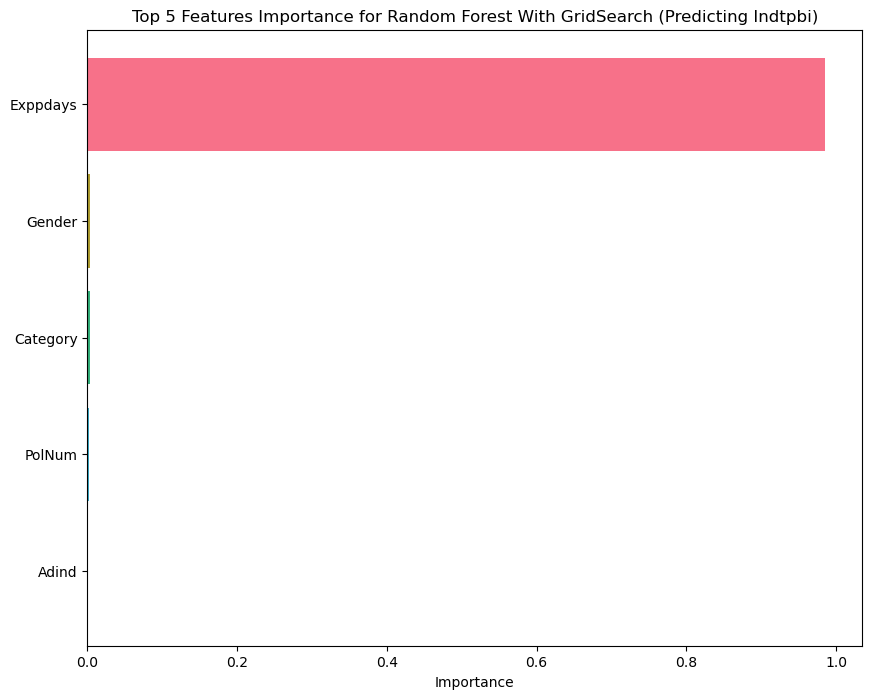

In [94]:
# Retrieve the best estimator
best_rf_model = grid_search_RF_GSCV.best_estimator_
feature_importances = best_rf_model.feature_importances_

# List of feature names
feature_names = ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus_processed', 'Exppdays',
                     'Numtpbi', 'Indtppd_processed', 'Numtppd']

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)

# Select the top 5 most important features
top_5_idx = sorted_idx[-5:]

# Define your custom color palette
custom_palette = sns.color_palette("husl", 5) 

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(range(5), feature_importances[top_5_idx][::-1], color=custom_palette)
plt.yticks(range(5), np.array(feature_names)[top_5_idx][::-1])  # Reverse the order for display
plt.xlabel('Importance')
plt.title('Top 5 Features Importance for Random Forest With GridSearch (Predicting Indtpbi)')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


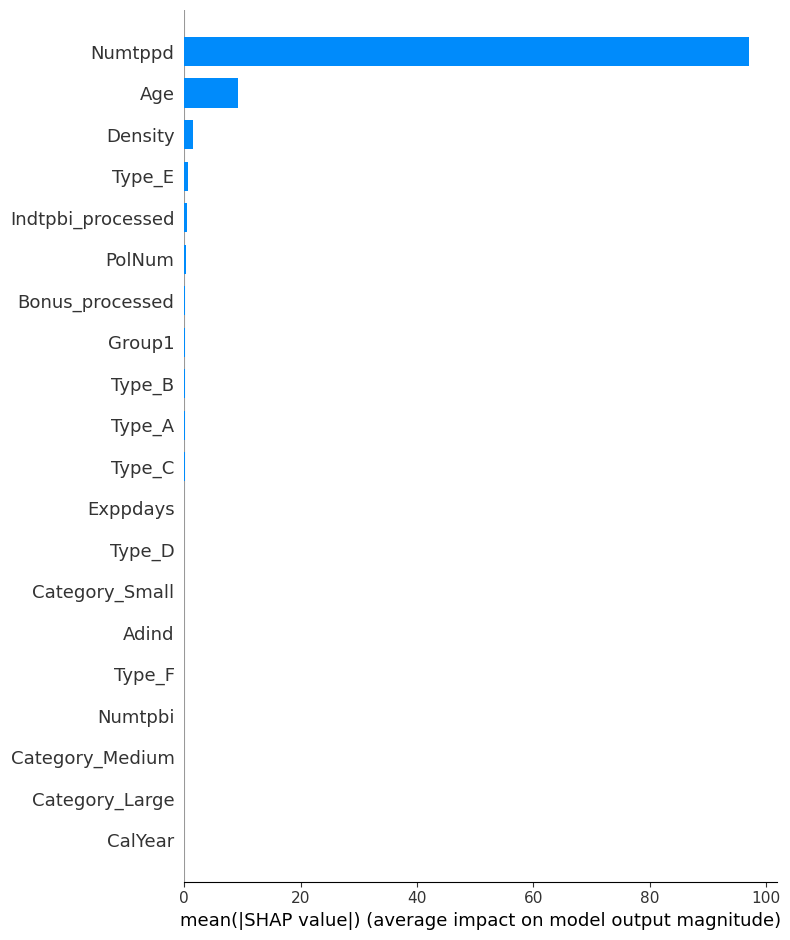

In [97]:
# One-hot encode categorical features
X_Ind_encoded = pd.get_dummies(X_Ind)

# Convert DataFrame to NumPy array
X_Ind_encoded_array = X_Ind_encoded.values

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_Ind_encoded_array)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_Ind_encoded_array, plot_type="bar", feature_names=X_Ind_encoded.columns)

In [98]:
# Create a DataFrame of SHAP values with feature names
shap_df = pd.DataFrame(shap_values, columns=X_Ind_encoded.columns)

# Display the DataFrame
shap_df.head()

,PolNum,CalYear,Age,Adind,Density,Bonus_processed,Exppdays,Group1,Numtpbi,Indtpbi_processed,Numtppd,Type_A,Type_B,Type_C,Type_D,Type_E,Type_F,Category_Large,Category_Medium,Category_Small
0,0.621193,0.003749,45.633964,0.045296,7.770560,1.112829,0.247661,-0.645801,0.062829,-1.507922,397.009826,-0.299076,0.476260,1.134762,-0.110123,2.026923,-0.020256,0.003057,0.000633,-0.068264
1,0.891399,0.003304,27.732731,-0.057148,7.538226,1.335201,0.133219,-0.853965,0.053343,-1.506408,381.825509,-0.298879,0.242920,-0.192693,-0.110029,-14.724421,-0.020296,-0.042045,-0.028812,-0.068197
2,0.741975,0.004364,26.987721,-0.147547,7.784135,0.971573,0.173171,-1.002432,0.059118,-1.615576,381.851341,-0.424879,0.248000,-0.192943,-0.106938,-15.016598,-0.027398,-0.042220,-0.007428,-0.067983
3,0.454342,0.004866,44.951579,0.047192,7.876224,-0.020014,0.259261,-0.844725,0.068615,-1.641922,396.221916,-0.318859,0.558643,1.135829,-0.143694,1.993240,-0.027362,0.016026,-0.047105,-0.067998
4,0.689371,0.003749,44.766590,0.066397,7.665335,1.114804,0.247661,-0.598271,0.062829,-1.545026,396.199899,-0.298910,0.476260,-0.169367,0.257009,2.044483,-0.020255,-0.079823,0.000633,-0.068264


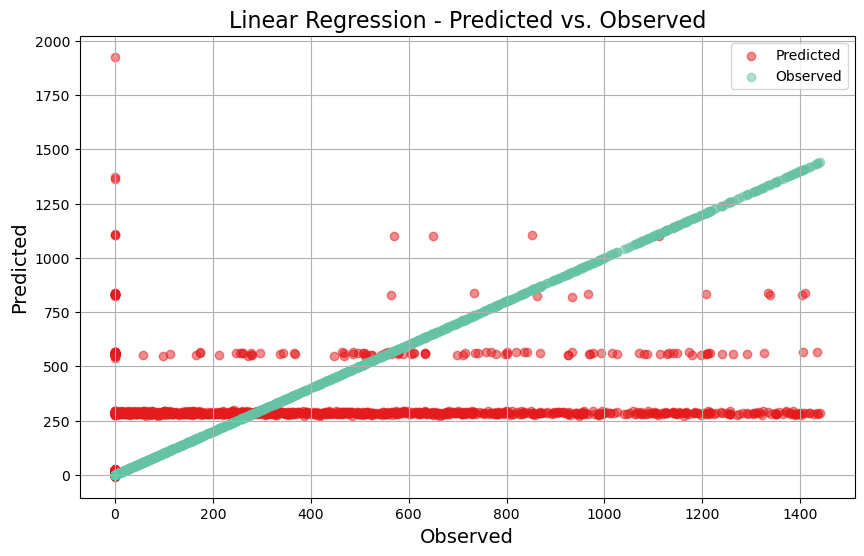

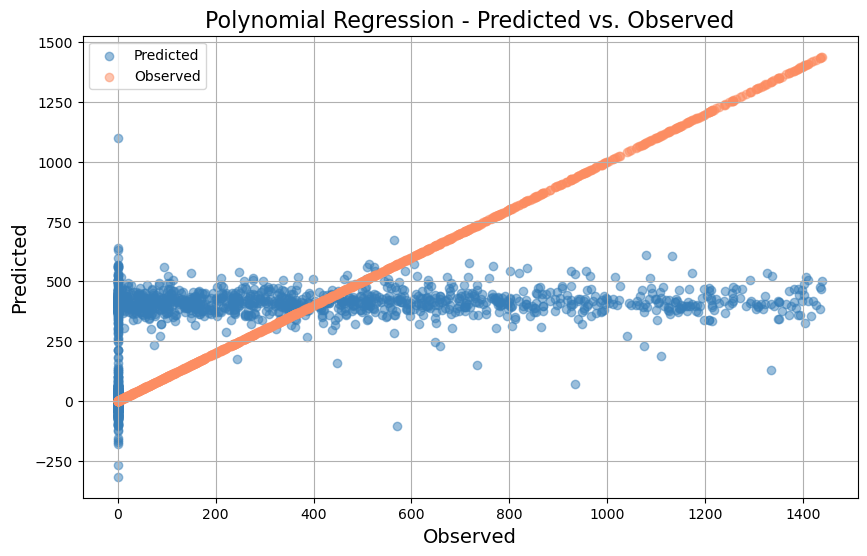

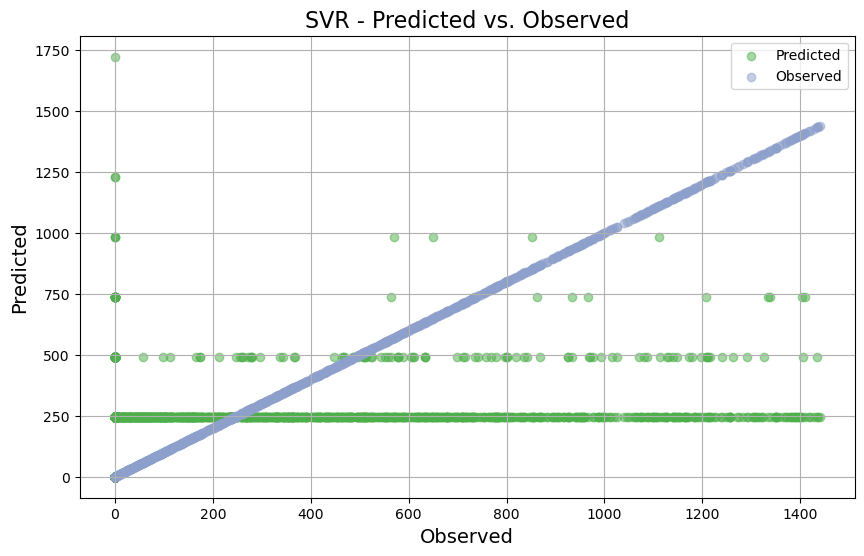

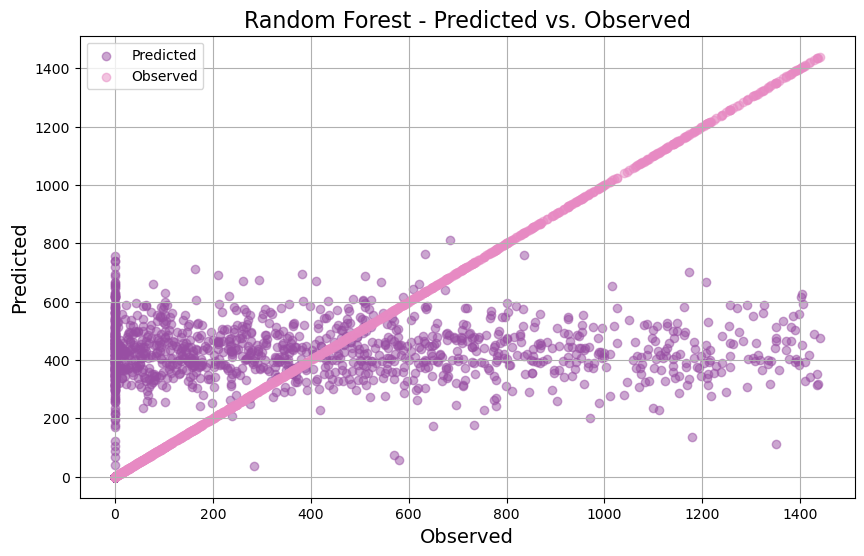

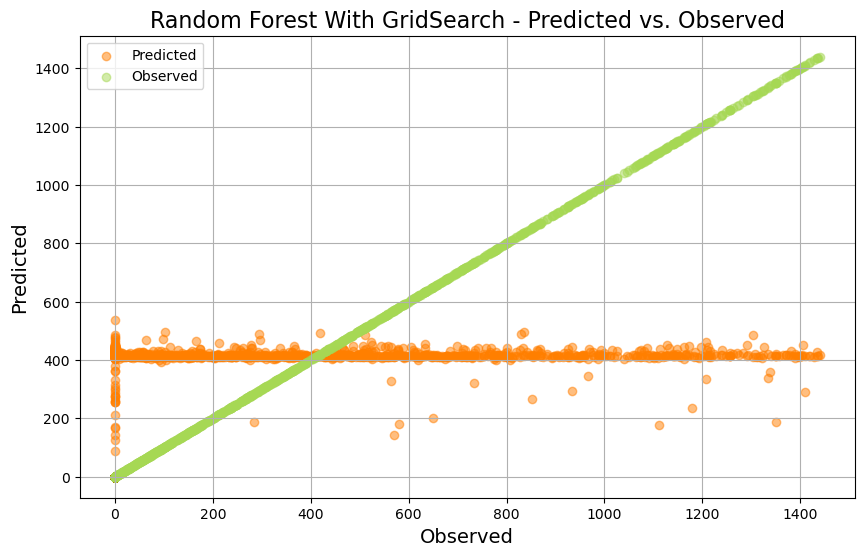

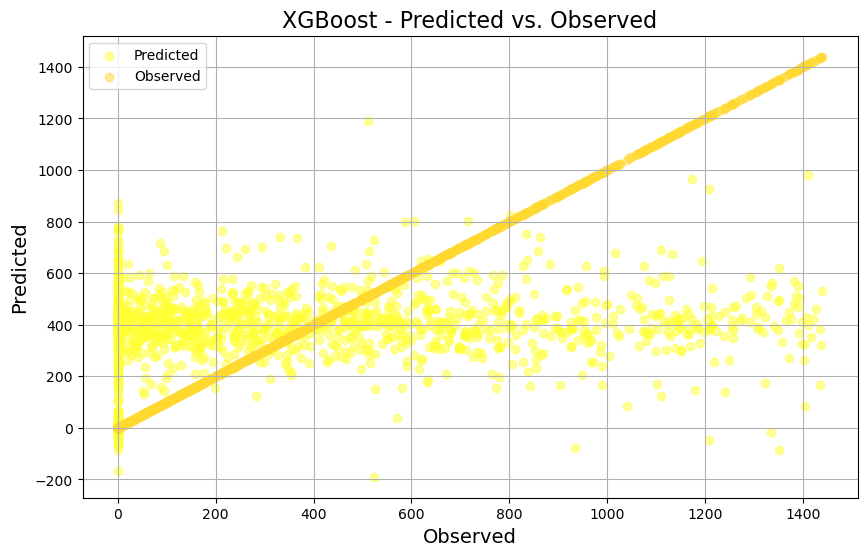

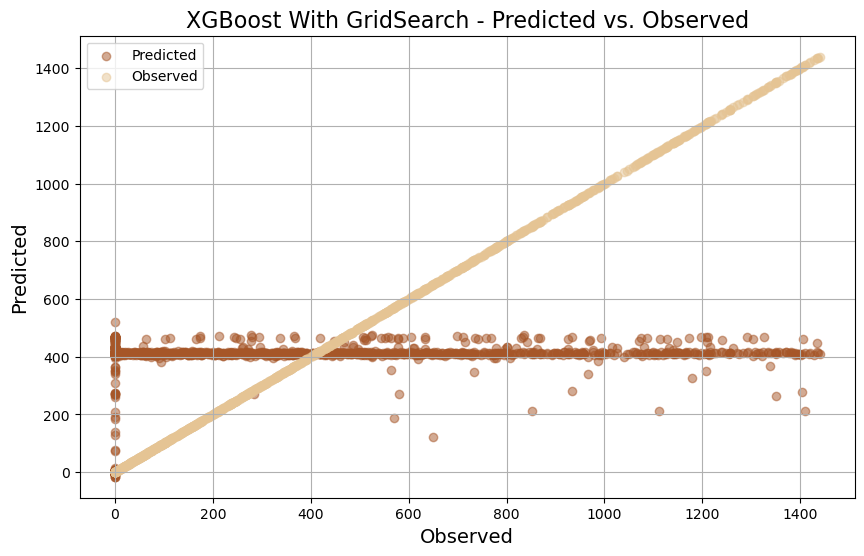

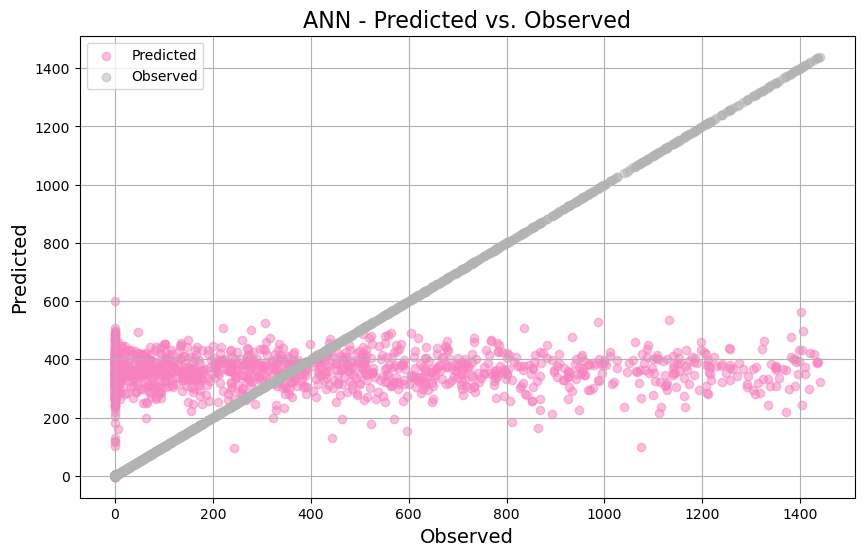

In [99]:
# Define palette of colors
palette_pred = sns.color_palette("Set1", n_colors=len(model_names))
palette_obs = sns.color_palette("Set2", n_colors=len(model_names))

# List of model names
model_names = ['Linear Regression', 'Polynomial Regression', 'SVR', 'Random Forest', 'Random Forest With GridSearch', 'XGBoost', 'XGBoost With GridSearch', 'ANN']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin_Ind, test_predict_poly_Ind, test_predict_svr_Ind, test_predict_rf_Ind, y_pred_rf_grid_Ind, y_pred_xgb_Ind, y_pred_xgb_grid_Ind, y_pred_rnn_Ind]

# Create DataFrame for predictions
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})

# Add observed values to the DataFrame
df_predictions['Observed'] = y_test_Ind.values

# Plotting predictions vs. observed for each model with different colors for predicted and observed values
for i, model in enumerate(model_names):
    plt.figure(figsize=(10, 6))
    plt.scatter(df_predictions['Observed'], df_predictions[f'y_pred_{model}'], alpha=0.5, color=palette_pred[i], label='Predicted')
    plt.scatter(df_predictions['Observed'], df_predictions['Observed'], alpha=0.5, color=palette_obs[i], label='Observed')
    plt.title(f'{model} - Predicted vs. Observed', fontsize=16)
    plt.xlabel('Observed', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

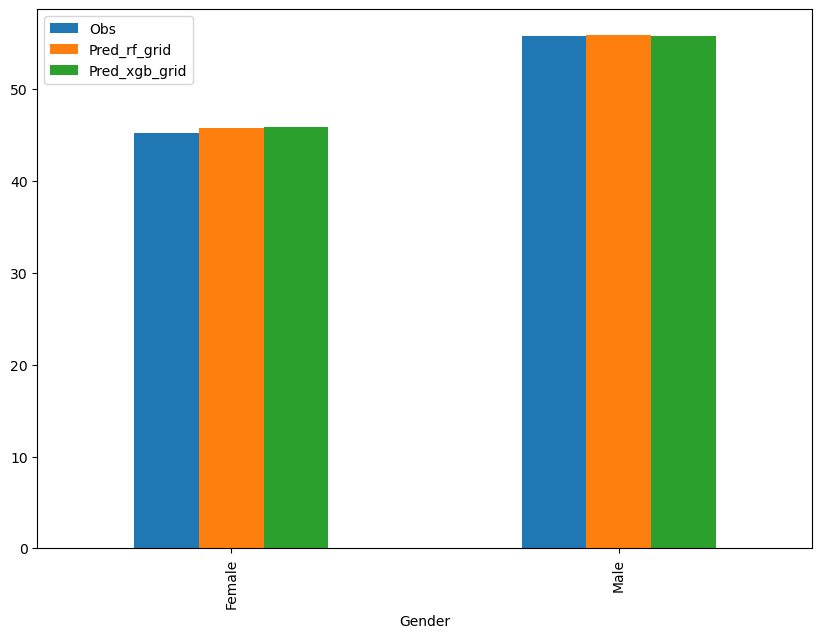

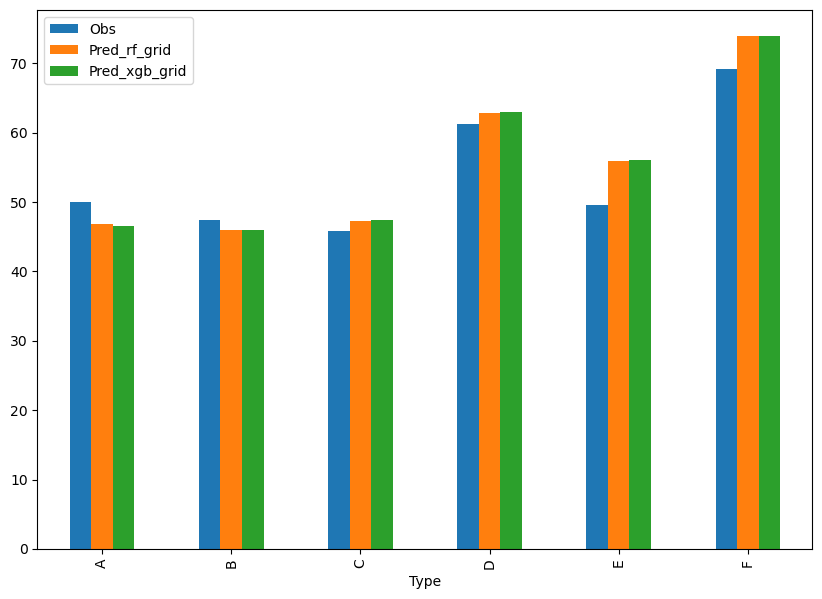

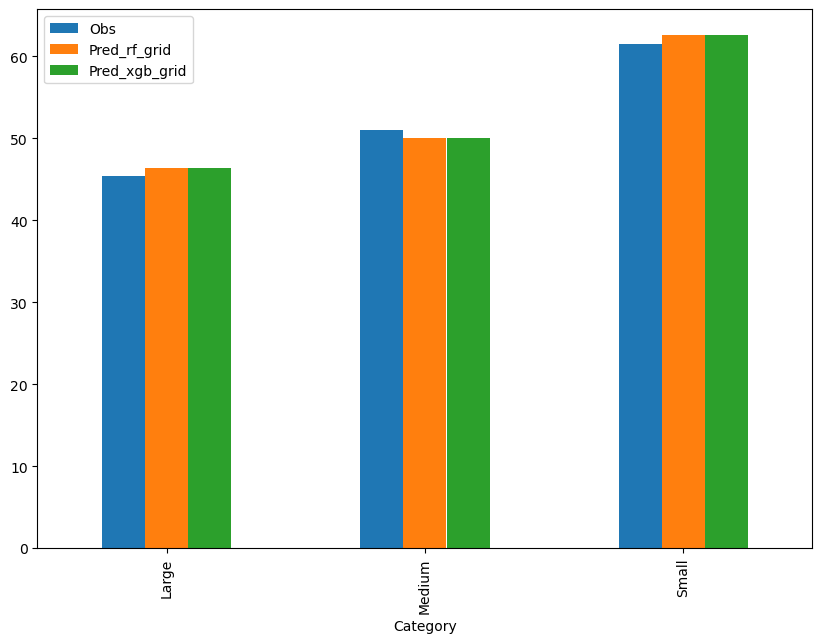

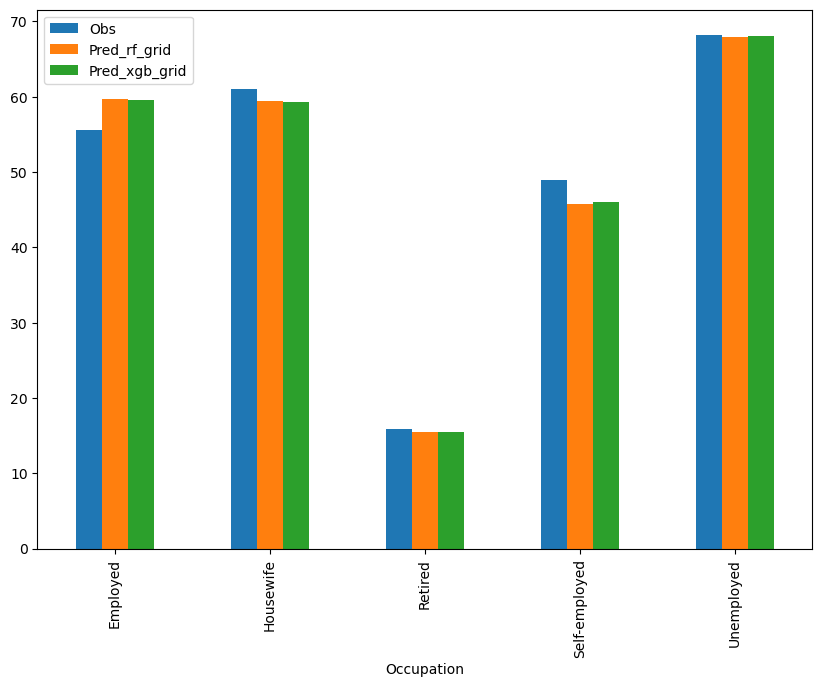

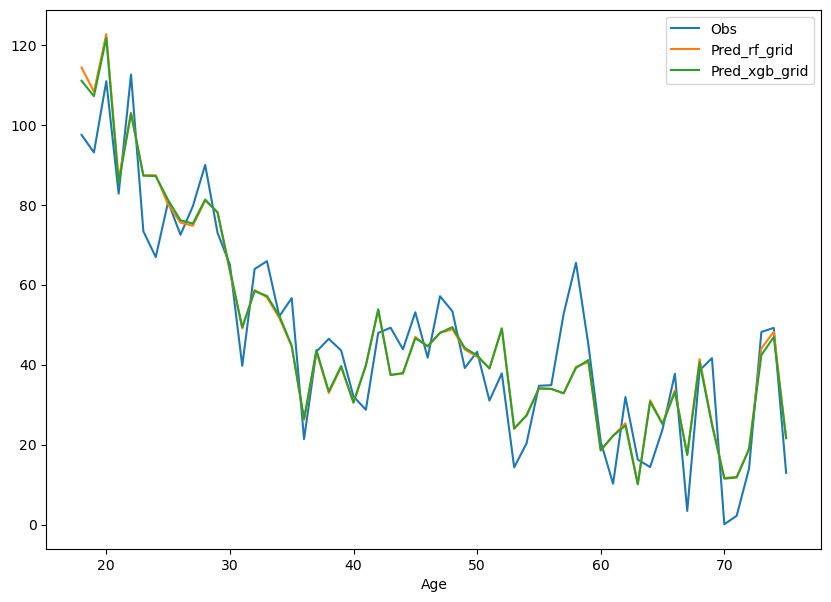

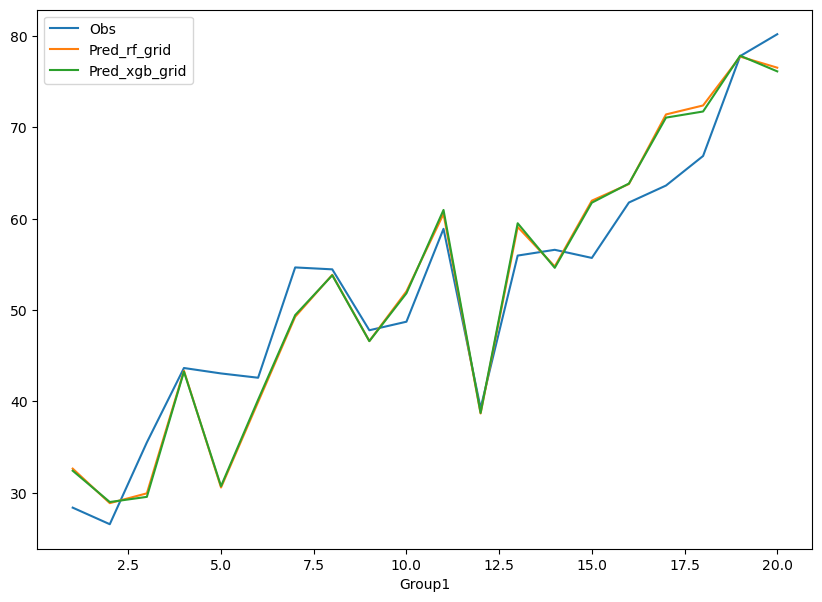

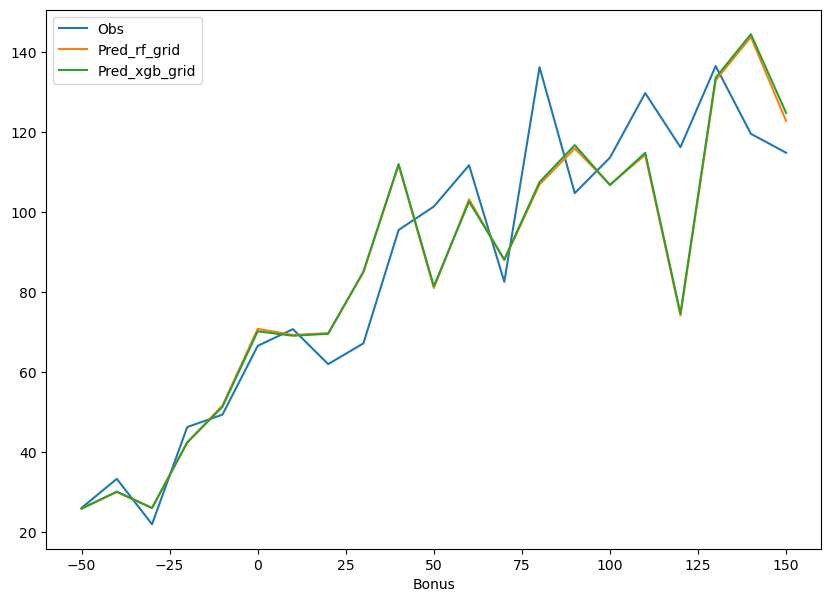

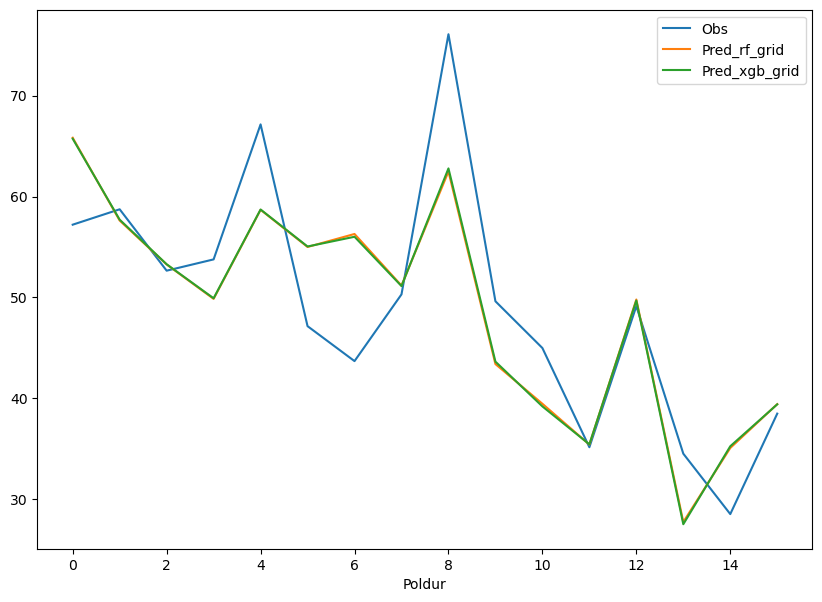

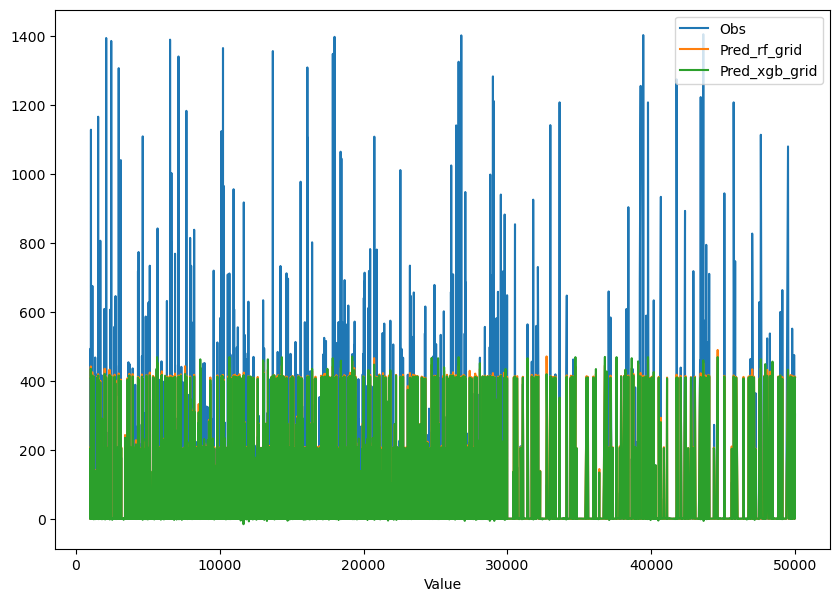

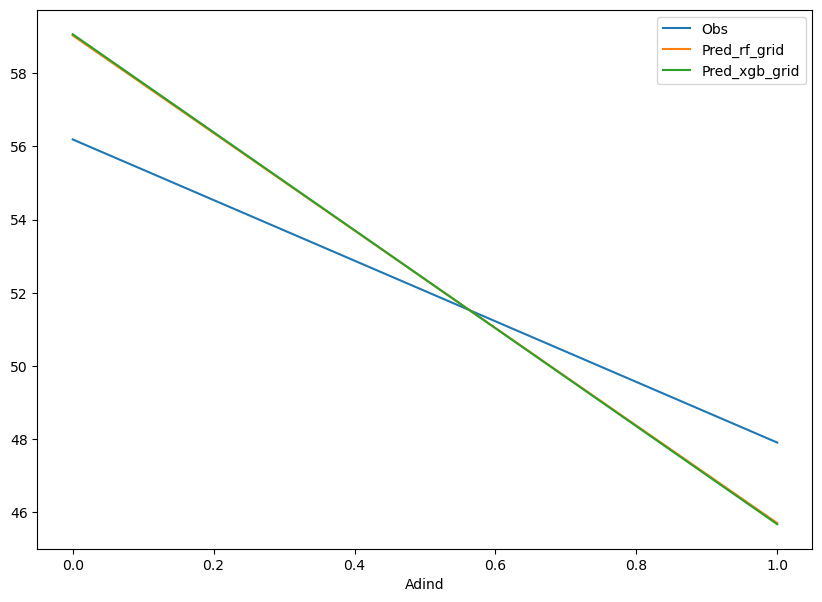

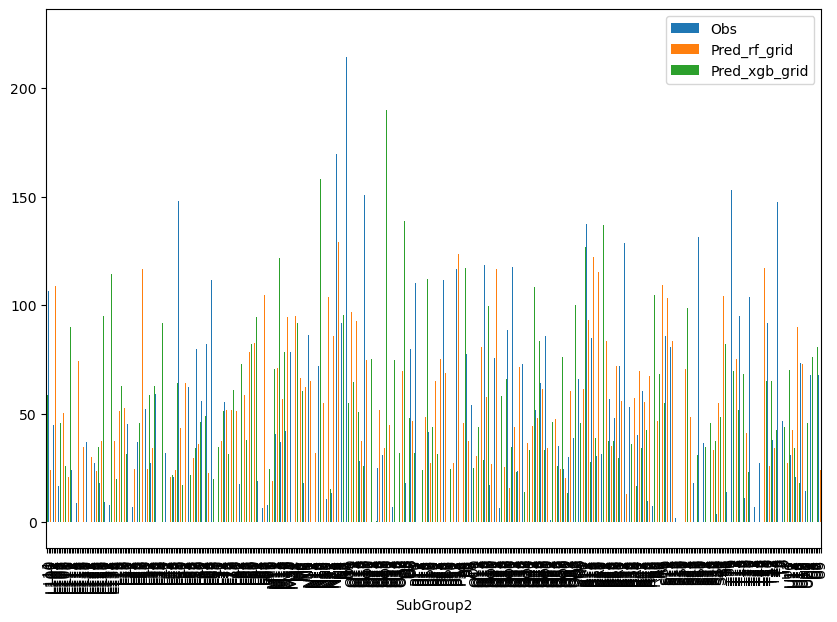

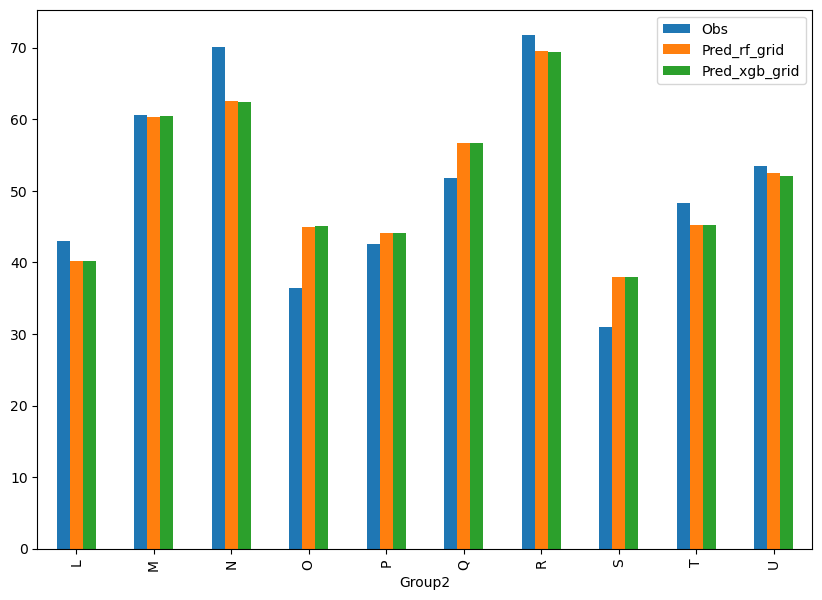

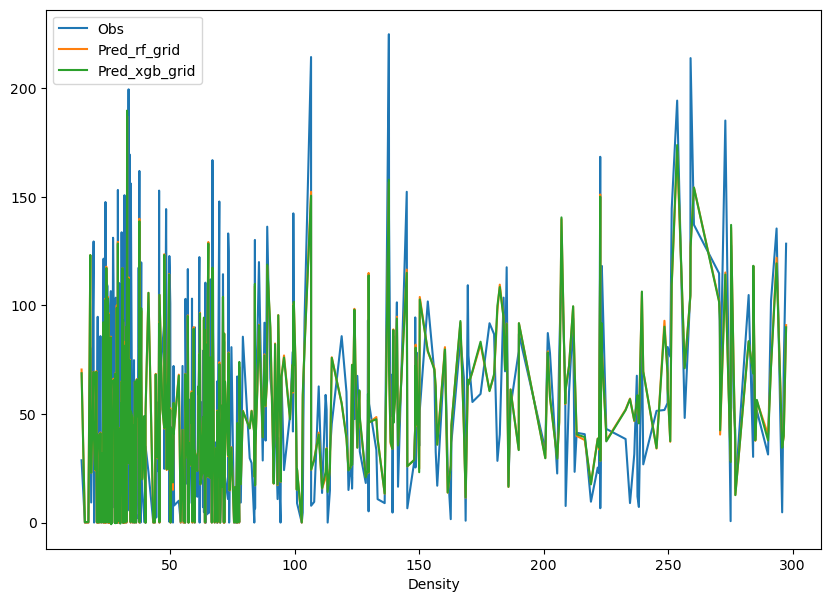

In [100]:
#Impact of target variable on the remaining variables
dataProv = pd.DataFrame(y_test.index)
dataProv.columns = ['index']
dataProv['Obs'] = np.array(y_test_Ind)
dataProv['Pred_rf_grid'] = y_pred_rf_grid_Ind
dataProv['Pred_xgb_grid'] = y_pred_xgb_grid_Ind
# dataProv['Pred_xgb_grid'] = p_xgb_grid
dataProv.head()

dataFinale = training_data.copy().reset_index().merge(dataProv)
dataFinale.head()
palette = "deep"

for var in dataFinale.columns[3:16]:
    dataPlot = dataFinale.groupby([var])[['Obs', 'Pred_rf_grid', 'Pred_xgb_grid']].mean()
    
    if dataFinale[var].dtypes == 'O':
        # Créer un graphique à barres avec des couleurs de la palette
        ax = dataPlot.plot(kind='bar', figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))
    else:
        # Créer un graphique linéaire avec des couleurs de la palette
        ax = dataPlot.plot(figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))

plt.show()

#### Step B : Predicting Prime PPD

In [109]:
# List of model names
model_names = ['Linear Regression', 'Polynomial Regression', 'Random Forest', 'Random Forest With GridSearch', 'XGBoost', 'XGBoost With GridSearch', 'ANN']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin, test_predict_poly, test_predict_rf_model, y_pred_rf_grid_model, y_pred_xgb_model, y_pred_xgb_grid_model, y_pred_ann_model]

# List of true values for comparison
y_true = y_test  # Assuming y_test contains the true values

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_true, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_true, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_true, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_true, y_pred) for y_pred in all_y_pred]
}

# Debugging: Print shapes of all_y_pred
for i, y_pred in enumerate(all_y_pred):
    print(f'Shape of y_pred_{model_names[i]}: {y_pred.shape}')

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
(df_predictions)

Shape of y_pred_Linear Regression: (10003,)
Shape of y_pred_Polynomial Regression: (10003,)
Shape of y_pred_Random Forest: (10003,)
Shape of y_pred_Random Forest With GridSearch: (10003,)
Shape of y_pred_XGBoost: (10003,)
Shape of y_pred_XGBoost With GridSearch: (10003,)
Shape of y_pred_ANN: (10003, 1)

Predictions DataFrame:


,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_Random Forest,y_pred_Random Forest With GridSearch,y_pred_XGBoost,y_pred_XGBoost With GridSearch,y_pred_ANN
0,-9.292514,-3.410605e-13,0.000000,0.000000,0.001428,-0.002468,0.415121
1,701.372277,5.694124e+02,569.252719,569.252719,570.997742,571.009521,587.257874
2,-7.281855,1.136868e-13,0.000000,0.000000,0.001359,-0.000320,0.401984
3,-12.693154,-1.364242e-12,0.000000,0.000000,0.001428,0.001026,0.265916
4,-8.458021,1.705303e-13,0.000000,0.000000,0.001428,-0.000350,0.305245
...,...,...,...,...,...,...,...
9998,-6.978366,1.136868e-13,0.000000,0.000000,0.001359,-0.002468,0.387694
9999,-3.727110,4.547474e-13,0.000000,0.000000,0.001359,-0.002693,0.363420
10000,-9.357432,5.115908e-13,0.000000,0.000000,0.001428,-0.003226,0.233145
10001,200.606354,1.705303e-13,0.000000,0.000000,0.022022,-1.112706,4.273314


In [110]:
print("\nMetrics DataFrame:")
(df_metrics)


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.725180e+01,1.036499e+04,1.018086e+02,0.850802
1,Polynomial Regression,7.260327e-13,1.103217e-23,3.321472e-12,1.000000
2,Random Forest,2.845830e-01,1.347071e+02,1.160634e+01,0.998061
3,Random Forest With GridSearch,2.845830e-01,1.347071e+02,1.160634e+01,0.998061
4,XGBoost,3.881468e-01,1.016762e+02,1.008346e+01,0.998536
5,XGBoost With GridSearch,4.209922e-01,7.967328e+01,8.925989e+00,0.998853
6,ANN,2.053562e+00,6.562634e+01,8.101009e+00,0.999055
